# Models Fusion

## Set up

###  Install required packages.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 84.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.8 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-v7i74txh
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-v7i74txh
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 6173d6e7bfb0192c39e442b6cf4744cbf531a5fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1234822 sha256=c70f15a5dd11f839f5e0d573d3706f062d472bbb911e8ac9c1e3c5f93878ed8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-9cqu6

### Unzip Data and Utils

In [2]:
!unzip "utils.zip" -d '.'

Archive:  utils.zip
   creating: ./utils/
   creating: ./utils/__pycache__/
  inflating: ./__MACOSX/utils/.___pycache__  
  inflating: ./utils/threshold.py    
  inflating: ./utils/comparing.py    
  inflating: ./utils/__pycache__/comparing.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._comparing.cpython-312.pyc  
  inflating: ./utils/__pycache__/threshold.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._threshold.cpython-312.pyc  


In [3]:
!unzip "data.zip" -d '.'

Streaming output truncated to the last 5000 lines.
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2024-5-2-NovaMind/._@openzeppelin  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/._0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/._0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/0x9bc699780A326C059C660C6ee2EF1D8583D01aEa.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/._0x9bc699780A326C059C660C

### Import and Var

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
import pandas as pd
from pathlib import Path
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_networkx

from utils.comparing import report_for_multiple_model_as_same_set, evaluate_multilabel_classification
from utils.threshold import tune_thresholds

PATH = './data/labeled'

## Load Data

In [6]:
def load_feature(file):
    df = pd.read_csv(os.path.join(PATH, file), index_col=0)
    df.index = df.index.str.lower()
    return df

In [7]:
def plot_confusion_matrix(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [8]:
y = load_feature('groundtruth.csv')
label_cols = [col for col in y.columns]
y.index = y.index.str.lower()
addresses = y.index.tolist()

### Split Train

In [9]:
train_idx, test_idx = train_test_split(addresses, test_size=0.3, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

## Individual Model

In [10]:
# for txn static, bytecode
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for source code
from sklearn.linear_model import LogisticRegression

# tuning
import optuna
from sklearn.metrics import f1_score

### Txn Static Feature Model

#### Base

In [11]:
df = load_feature('transaction_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
txn_train_idx = [idx for idx in train_idx if idx in df.index]
txn_test_idx = [idx for idx in test_idx if idx in df.index]

txn_X_train = df.loc[txn_train_idx]
txn_X_test = df.loc[txn_test_idx]
txn_y_train = y_train.loc[txn_train_idx]
txn_y_test = y_test.loc[txn_test_idx]

In [12]:
txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



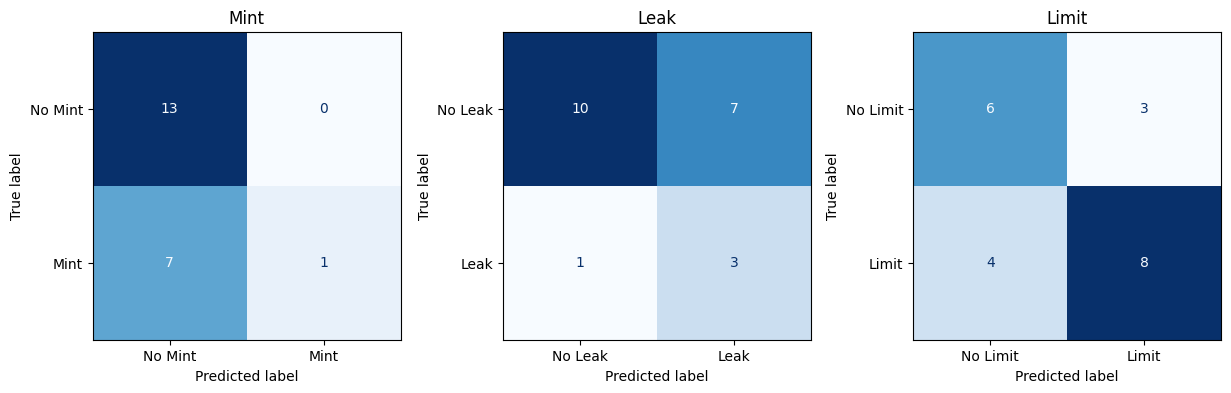

In [13]:
y_pred = txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

#### Tuning

In [14]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(txn_X_train, txn_y_train)
    y_pred = clf.predict(txn_X_test)
    return f1_score(txn_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-29 14:46:42,631] A new study created in memory with name: no-name-76f6a086-c51d-4155-be3c-75a2e8d66640
[I 2025-07-29 14:46:43,645] Trial 0 finished with value: 0.4488152749022314 and parameters: {'n_estimators': 215, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.4488152749022314.
[I 2025-07-29 14:46:44,878] Trial 1 finished with value: 0.441407867494824 and parameters: {'n_estimators': 268, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4488152749022314.
[I 2025-07-29 14:46:45,582] Trial 2 finished with value: 0.441407867494824 and parameters: {'n_estimators': 139, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4488152749022314.
[I 2025-07-29 14:46:46,927] Trial 3 finished with value: 0.441407867494824 and parameters: {'n_estimators': 295, 'max_depth': 21, 'min_

Best Params: {'n_estimators': 215, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best Score: 0.4488152749022314


##### Evaluation

In [15]:
tuned_txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=29,
                                                       max_features='log2',
                                                       min_samples_split=3,
                                                       n_estimators=215,
                                                       random_state=42))

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



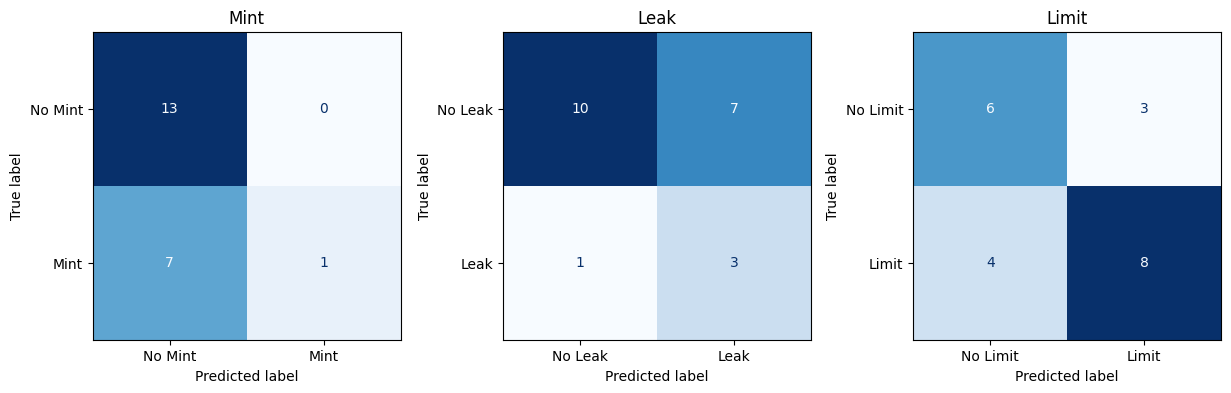

In [16]:
y_pred = tuned_txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

### Bytecode Static Feature Model

#### Base

In [17]:
df = load_feature('bytecode_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
byte_train_idx = [idx for idx in train_idx if idx in df.index]
byte_test_idx = [idx for idx in test_idx if idx in df.index]

byte_X_train = df.loc[byte_train_idx]
byte_X_test = df.loc[byte_test_idx]
byte_y_train = y_train.loc[byte_train_idx]
byte_y_test = y_test.loc[byte_test_idx]

In [18]:
byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.25      0.40         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.79      0.40      0.51        24
weighted avg       0.76      0.46      0.55        24
 samples avg       0.37      0.36      0.35        24



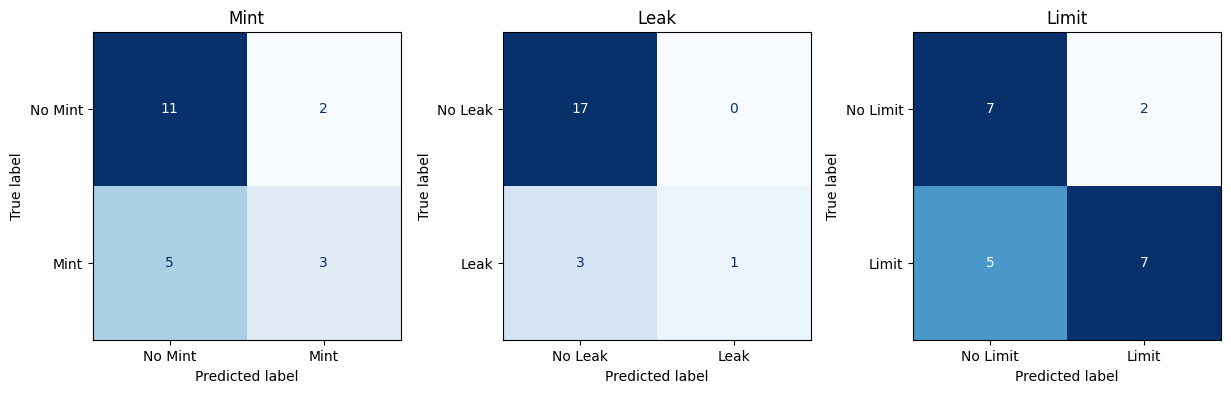

In [19]:
y_pred = byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

#### Tuning

In [20]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(byte_X_train, byte_y_train)
    y_pred = clf.predict(byte_X_test)
    return f1_score(byte_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-29 14:50:31,276] A new study created in memory with name: no-name-af39ca10-7f1e-44da-834e-1bceb466fd93
[I 2025-07-29 14:50:33,281] Trial 0 finished with value: 0.565079365079365 and parameters: {'n_estimators': 261, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.565079365079365.
[I 2025-07-29 14:50:34,031] Trial 1 finished with value: 0.5094017094017094 and parameters: {'n_estimators': 118, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.565079365079365.
[I 2025-07-29 14:50:35,278] Trial 2 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 258, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.565079365079365.
[I 2025-07-29 14:50:36,415] Trial 3 finished with value: 0.37606837606837606 and parameters: {'n_estimators': 217, 'max_depth': 9, 'min_sa

Best Params: {'n_estimators': 111, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}
Best Score: 0.6126984126984127


##### Evaluation

In [21]:
tuned_byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=22,
                                                       max_features='log2',
                                                       min_samples_leaf=3,
                                                       min_samples_split=10,
                                                       n_estimators=111,
                                                       random_state=42))

              precision    recall  f1-score   support

        Mint       0.67      0.50      0.57         8
        Leak       1.00      0.50      0.67         4
       Limit       0.75      0.50      0.60        12

   micro avg       0.75      0.50      0.60        24
   macro avg       0.81      0.50      0.61        24
weighted avg       0.76      0.50      0.60        24
 samples avg       0.41      0.40      0.40        24



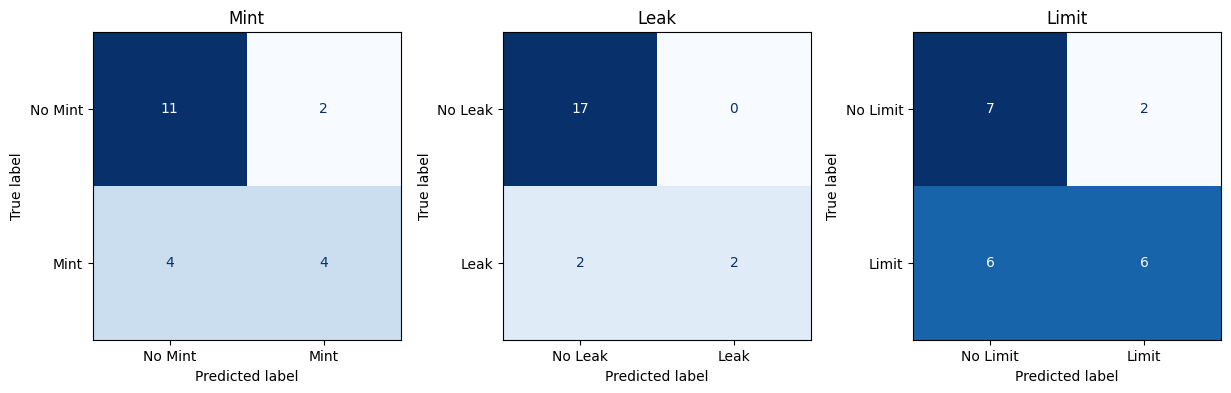

In [22]:
y_pred = tuned_byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

### Source Code Static Feature Model

#### Base

In [23]:
df = load_feature('tf_idf.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
source_train_idx = [idx for idx in train_idx if idx in df.index]
source_test_idx = [idx for idx in test_idx if idx in df.index]

source_X_train = df.loc[source_train_idx]
source_X_test = df.loc[source_test_idx]
source_y_train = y_train.loc[source_train_idx]
source_y_test = y_test.loc[source_test_idx]

In [24]:
source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42))
source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.50      0.86      0.63         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.62      0.59      0.60        22
   macro avg       0.75      0.55      0.55        22
weighted avg       0.72      0.59      0.59        22
 samples avg       0.50      0.43      0.44        22



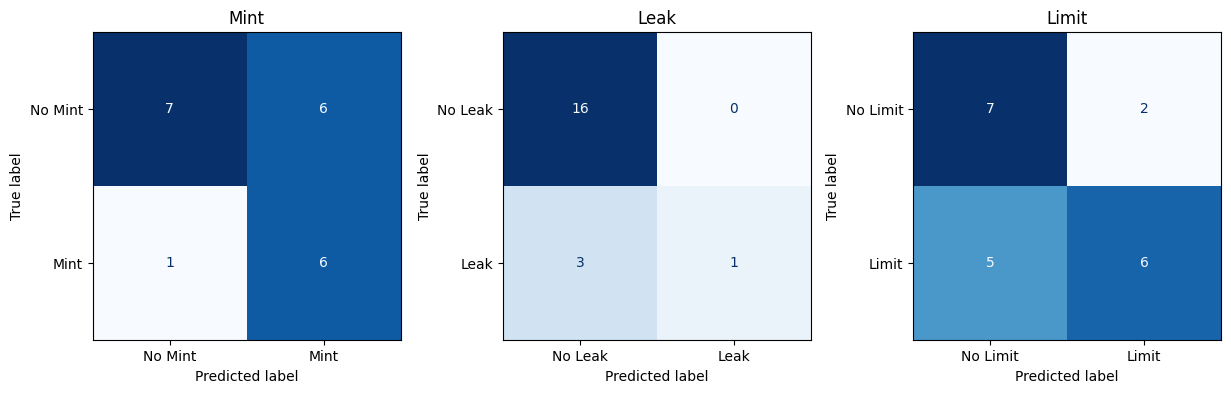

In [25]:
y_pred = source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

#### Tuning

In [26]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-6, 10, log=True),  # regularization strength
        "solver": trial.suggest_categorical(
            "solver", ["liblinear", "saga"]  # both support l1 and l2
        ),
        "max_iter": trial.suggest_int("max_iter", 100, 2000),
    }

    clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **params))
    clf.fit(source_X_train, source_y_train)
    y_pred = clf.predict(source_X_test)
    return f1_score(source_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-29 14:52:45,084] A new study created in memory with name: no-name-6643aa1e-72e1-4d81-965c-5e0c7867e517
[I 2025-07-29 14:52:45,221] Trial 0 finished with value: 0.5238095238095237 and parameters: {'penalty': 'l2', 'C': 0.009224329781837674, 'solver': 'liblinear', 'max_iter': 168}. Best is trial 0 with value: 0.5238095238095237.
[I 2025-07-29 14:52:45,387] Trial 1 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.06026600892008154, 'solver': 'liblinear', 'max_iter': 647}. Best is trial 0 with value: 0.5238095238095237.
[I 2025-07-29 14:52:45,542] Trial 2 finished with value: 0.5238095238095237 and parameters: {'penalty': 'l2', 'C': 3.571548818833211e-05, 'solver': 'liblinear', 'max_iter': 537}. Best is trial 0 with value: 0.5238095238095237.
[I 2025-07-29 14:52:45,835] Trial 3 finished with value: 0.23655913978494625 and parameters: {'penalty': 'l2', 'C': 6.851758331357994e-05, 'solver': 'saga', 'max_iter': 475}. Best is trial 0 with value: 0.5238095238095237.


Best Params: {'penalty': 'l2', 'C': 4.325459988781796, 'solver': 'liblinear', 'max_iter': 1312}
Best Score: 0.6295739348370927


##### Evaluation

In [27]:
tuned_source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **study.best_params))
tuned_source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=4.325459988781796,
                                                   class_weight='balanced',
                                                   max_iter=1312,
                                                   random_state=42,
                                                   solver='liblinear'))

              precision    recall  f1-score   support

        Mint       0.86      0.86      0.86         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.81      0.59      0.68        22
   macro avg       0.87      0.55      0.63        22
weighted avg       0.83      0.59      0.66        22
 samples avg       0.53      0.43      0.46        22



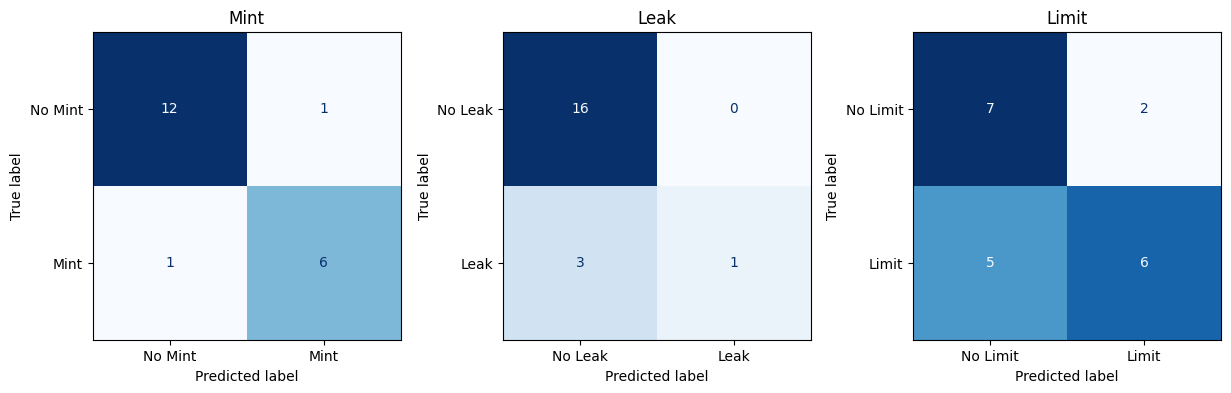

In [28]:
y_pred = tuned_source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

### Transaction Time Series

#### import lib

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from optuna.integration import TFKerasPruningCallback

#### load data

In [42]:
seq_len = 500
feature_dim = 12

ts_X_train, ts_X_test, ts_y_train, ts_y_test, ts_test_idx  = [], [], [], [], []

for path in tqdm(list(Path(os.path.join(PATH, 'txn')).glob('*.json'))):
    addr = path.stem
    data = json.load(open(path, 'r'))
    txns = sorted(data.get("transaction", []), key=lambda x: int(x.get("timeStamp", 0)))
    seq = [[
        int(tx.get("blockNumber", 0)),
        int(tx.get("timeStamp", 0)),
        int(tx.get("nonce", 0)),
        int(tx.get("transactionIndex", 0)),
        int(tx.get("value", 0)),
        int(tx.get("gas", 0)),
        int(tx.get("gasPrice", 0)),
        int(tx.get("isError", 0)),
        int(tx.get("txreceipt_status", 0)),
        int(tx.get("cumulativeGasUsed", 0)),
        int(tx.get("gasUsed", 0)),
        int(tx.get("confirmations", 0)),
    ] for tx in txns]

    if len(seq) < seq_len:
        seq += [[0]*feature_dim] * (seq_len - len(seq))
    else:
        seq = seq[:seq_len]

    seq = StandardScaler().fit_transform(seq)

    if addr in train_idx:
        ts_X_train.append(seq)
        ts_y_train.append(y.loc[addr].tolist())
    elif addr in test_idx:
        ts_X_test.append(seq)
        ts_y_test.append(y.loc[addr].tolist())
        ts_test_idx.append(addr)

100%|██████████| 69/69 [00:02<00:00, 32.18it/s]


In [43]:
ts_X_train = np.array(ts_X_train)
ts_X_test = np.array(ts_X_test)
ts_y_train = np.array(ts_y_train)
ts_y_test = np.array(ts_y_test)

#### tuning

In [58]:
epochs = 100

In [59]:
def build_gru_model(input_shape, units, lr, output):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        GRU(units),
        Dense(output, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

def scheduler(epoch, lr):
    return lr if epoch < 10 else lr * 0.9

In [62]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
lr_scheduler = LearningRateScheduler(scheduler)

In [64]:
def objective(trial):
    units = trial.suggest_int("units", 32, 516)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    model = build_gru_model(
        input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]),
        units=units, lr=lr,
        output=ts_y_train.shape[1]
    )

    model.fit(
        ts_X_train, ts_y_train,
        validation_data=(ts_X_test, ts_y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, lr_scheduler],
        verbose=1
    )

    y_pred = model.predict(ts_X_test)
    thresholds, _ = tune_thresholds(ts_y_test, y_pred)
    y_pred_bin = (y_pred > thresholds).astype(int)

    return f1_score(ts_y_test, y_pred_bin, average='macro')

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)


[I 2025-07-29 15:55:21,284] A new study created in memory with name: no-name-a1f22e26-d8dc-4548-a17f-93df75135edc


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2396 - loss: 0.6852 - val_accuracy: 0.3333 - val_loss: 0.6475 - learning_rate: 0.0012
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4141 - loss: 0.6159 - val_accuracy: 0.1905 - val_loss: 0.6224 - learning_rate: 0.0012
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3464 - loss: 0.5775 - val_accuracy: 0.4286 - val_loss: 0.6429 - learning_rate: 0.0012
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6354 - loss: 0.5539 - val_accuracy: 0.1905 - val_loss: 0.5835 - learning_rate: 0.0012
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2995 - loss: 0.5455 - val_accuracy: 0.1905 - val_loss: 0.5911 - learning_rate: 0.0012
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3620 - loss: 0.5405 - val_accuracy: 0.1905 - val_loss: 0.5905 - learning_rate: 0.0012
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2839 - loss: 0.5319 - val_accuracy: 0.2381 - v

[I 2025-07-29 15:56:31,774] Trial 0 finished with value: 0.6351981351981352 and parameters: {'units': 497, 'lr': 0.0011773366361227985, 'batch_size': 16}. Best is trial 0 with value: 0.6351981351981352.


Label 2: Best threshold = 0.49, Best f1 = 0.7692307692307693
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3611 - loss: 0.6869 - val_accuracy: 0.2381 - val_loss: 0.6848 - learning_rate: 1.7467e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3090 - loss: 0.6788 - val_accuracy: 0.2381 - val_loss: 0.6803 - learning_rate: 1.7467e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3229 - loss: 0.6730 - val_accuracy: 0.2381 - val_loss: 0.6759 - learning_rate: 1.7467e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3125 - loss: 0.6675 - val_accuracy: 0.2381 - val_loss: 0.6716 - learning_rate: 1.7467e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3125 - loss: 0.6582 - val_accuracy: 0.2381 - val_loss: 0.6675 - learning_rate: 1.7467e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2812 - loss: 0.6571 - val_accuracy: 0.2381 - val_loss: 0.6636 - learning_rate: 1.7467e-04
Epoch 7/100
2/2 ━━━━━━━━━━━

[I 2025-07-29 16:02:47,924] Trial 1 finished with value: 0.6503052503052503 and parameters: {'units': 347, 'lr': 0.0001746724231807774, 'batch_size': 32}. Best is trial 1 with value: 0.6503052503052503.


Label 2: Best threshold = 0.46, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5208 - loss: 0.6927 - val_accuracy: 0.2381 - val_loss: 0.6559 - learning_rate: 0.0016
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2639 - loss: 0.6393 - val_accuracy: 0.2381 - val_loss: 0.6276 - learning_rate: 0.0016
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3299 - loss: 0.6078 - val_accuracy: 0.2381 - val_loss: 0.6125 - learning_rate: 0.0016
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3507 - loss: 0.5521 - val_accuracy: 0.3810 - val_loss: 0.7544 - learning_rate: 0.0016
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4826 - loss: 0.6266 - val_accuracy: 0.2381 - val_loss: 0.5929 - learning_rate: 0.0016
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3299 - loss: 0.5215 - val_accuracy: 0.2381 - val_loss: 0.5827 - learning_rate: 0.0016
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - a

[I 2025-07-29 16:03:47,990] Trial 2 finished with value: 0.6590909090909091 and parameters: {'units': 346, 'lr': 0.0015799986967301911, 'batch_size': 32}. Best is trial 2 with value: 0.6590909090909091.


Label 2: Best threshold = 0.21, Best f1 = 0.75
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5677 - loss: 0.6823 - val_accuracy: 0.2857 - val_loss: 0.6804 - learning_rate: 3.3510e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3568 - loss: 0.6747 - val_accuracy: 0.2857 - val_loss: 0.6716 - learning_rate: 3.3510e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3177 - loss: 0.6610 - val_accuracy: 0.2857 - val_loss: 0.6639 - learning_rate: 3.3510e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3802 - loss: 0.6409 - val_accuracy: 0.2857 - val_loss: 0.6563 - learning_rate: 3.3510e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3073 - loss: 0.6385 - val_accuracy: 0.2857 - val_loss: 0.6490 - learning_rate: 3.3510e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 922ms/step - accuracy: 0.3385 - loss: 0.6190 - val_accuracy: 0.2381 - val_loss: 0.6415 - learning_rate: 3.3510e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5

[I 2025-07-29 16:08:43,511] Trial 3 finished with value: 0.6444444444444445 and parameters: {'units': 242, 'lr': 0.00033510059349595633, 'batch_size': 16}. Best is trial 2 with value: 0.6590909090909091.


Label 2: Best threshold = 0.42, Best f1 = 0.8
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3889 - loss: 0.6765 - val_accuracy: 0.5238 - val_loss: 0.8532 - learning_rate: 0.0072
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4861 - loss: 0.7046 - val_accuracy: 0.2381 - val_loss: 0.5865 - learning_rate: 0.0072
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3125 - loss: 0.5587 - val_accuracy: 0.1905 - val_loss: 0.5603 - learning_rate: 0.0072
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3333 - loss: 0.5384 - val_accuracy: 0.1429 - val_loss: 0.5638 - learning_rate: 0.0072
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2986 - loss: 0.5470 - val_accuracy: 0.2857 - val_loss: 0.5110 - learning_rate: 0.0072
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3611 - loss: 0.4663 - val_accuracy: 0.2381 - val_loss: 0.5048 - learning_rate: 0.0072
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.316

[I 2025-07-29 16:09:54,383] Trial 4 finished with value: 0.6842650103519669 and parameters: {'units': 416, 'lr': 0.007190923213514554, 'batch_size': 32}. Best is trial 4 with value: 0.6842650103519669.


Label 2: Best threshold = 0.17, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 652ms/step - accuracy: 0.3018 - loss: 0.6880 - val_accuracy: 0.1905 - val_loss: 0.6618 - learning_rate: 0.0013
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.4741 - loss: 0.6348 - val_accuracy: 0.2381 - val_loss: 0.6249 - learning_rate: 0.0013
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - accuracy: 0.3607 - loss: 0.5889 - val_accuracy: 0.1905 - val_loss: 0.5938 - learning_rate: 0.0013
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.3506 - loss: 0.5520 - val_accuracy: 0.1905 - val_loss: 0.5821 - learning_rate: 0.0013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - accuracy: 0.2771 - loss: 0.5297 - val_accuracy: 0.2381 - val_loss: 0.5859 - learning_rate: 0.0013
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 660ms/step - accuracy: 0.3083 - loss: 0.5154 - val_accuracy: 0.2381 - val_loss: 0.5682 - learning_rate: 0.0013
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:11:06,435] Trial 5 finished with value: 0.7059163059163059 and parameters: {'units': 163, 'lr': 0.001275456136021958, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.24, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2018 - loss: 0.7040 - val_accuracy: 0.3333 - val_loss: 0.7036 - learning_rate: 1.4363e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3048 - loss: 0.6913 - val_accuracy: 0.4286 - val_loss: 0.6938 - learning_rate: 1.4363e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4357 - loss: 0.6733 - val_accuracy: 0.4286 - val_loss: 0.6859 - learning_rate: 1.4363e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4938 - loss: 0.6723 - val_accuracy: 0.4762 - val_loss: 0.6781 - learning_rate: 1.4363e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4878 - loss: 0.6536 - val_accuracy: 0.4286 - val_loss: 0.6696 - learning_rate: 1.4363e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6080 - loss: 0.6411 - val_accuracy: 0.4286 - val_loss: 0.6618 - learning_rate: 1.4363e-04
Epoch 7/100
6/6 ━━━━━━━━

[I 2025-07-29 16:16:33,865] Trial 6 finished with value: 0.6358024691358025 and parameters: {'units': 371, 'lr': 0.00014362828774181646, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.42, Best f1 = 0.8148148148148148
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4201 - loss: 0.6756 - val_accuracy: 0.2857 - val_loss: 0.5976 - learning_rate: 0.0060
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4028 - loss: 0.6389 - val_accuracy: 0.5714 - val_loss: 0.9907 - learning_rate: 0.0060
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4653 - loss: 1.1490 - val_accuracy: 0.1429 - val_loss: 0.7372 - learning_rate: 0.0060
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3438 - loss: 0.6706 - val_accuracy: 0.4286 - val_loss: 0.6349 - learning_rate: 0.0030
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
Label 0: Best threshold = 0.45, Best f1 = 0.6363636363636364
Label 1: Best threshold = 0.22, Best f1 = 0.5


[I 2025-07-29 16:16:57,793] Trial 7 finished with value: 0.6287878787878788 and parameters: {'units': 363, 'lr': 0.006029721316441752, 'batch_size': 32}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.28, Best f1 = 0.75
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3724 - loss: 0.6981 - val_accuracy: 0.2857 - val_loss: 0.6603 - learning_rate: 0.0014
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3385 - loss: 0.6366 - val_accuracy: 0.2381 - val_loss: 0.6281 - learning_rate: 0.0014
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3047 - loss: 0.6050 - val_accuracy: 0.2381 - val_loss: 0.6046 - learning_rate: 0.0014
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3776 - loss: 0.5613 - val_accuracy: 0.2381 - val_loss: 0.6103 - learning_rate: 0.0014
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3281 - loss: 0.5354 - val_accuracy: 0.2381 - val_loss: 0.5736 - learning_rate: 0.0014
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3646 - loss: 0.5211 - val_accuracy: 0.2381 - val_loss: 0.5661 - learning_rate: 0.0014
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.322

[I 2025-07-29 16:17:43,150] Trial 8 finished with value: 0.6555555555555556 and parameters: {'units': 261, 'lr': 0.0013681203110525995, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 841ms/step - accuracy: 0.5781 - loss: 0.6878 - val_accuracy: 0.3810 - val_loss: 0.6693 - learning_rate: 0.0014
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - accuracy: 0.4453 - loss: 0.6454 - val_accuracy: 0.2381 - val_loss: 0.6457 - learning_rate: 0.0014
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step - accuracy: 0.2995 - loss: 0.6230 - val_accuracy: 0.2381 - val_loss: 0.6230 - learning_rate: 0.0014
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step - accuracy: 0.2786 - loss: 0.5906 - val_accuracy: 0.2381 - val_loss: 0.6064 - learning_rate: 0.0014
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3490 - loss: 0.5499 - val_accuracy: 0.2381 - val_loss: 0.6107 - learning_rate: 0.0014
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 649ms/step - accuracy: 0.3490 - loss: 0.5333 - val_accuracy: 0.2381 - val_loss: 0.5993 - learning_rate: 0.0014
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:18:13,813] Trial 9 finished with value: 0.6487179487179487 and parameters: {'units': 176, 'lr': 0.0014200125335492497, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.12, Best f1 = 0.5
Label 2: Best threshold = 0.45, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.2777 - loss: 0.7098 - val_accuracy: 0.1905 - val_loss: 0.7001 - learning_rate: 4.5743e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.2589 - loss: 0.7025 - val_accuracy: 0.2381 - val_loss: 0.6927 - learning_rate: 4.5743e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.2485 - loss: 0.6835 - val_accuracy: 0.2381 - val_loss: 0.6853 - learning_rate: 4.5743e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.2500 - loss: 0.6785 - val_accuracy: 0.2381 - val_loss: 0.6781 - learning_rate: 4.5743e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.2003 - loss: 0.6671 - val_accuracy: 0.2381 - val_loss: 0.6710 - learning_rate: 4.5743e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.2277 - loss: 0.6644 - val_accuracy: 0.2381 - val_loss

[I 2025-07-29 16:20:09,409] Trial 10 finished with value: 0.6703553756185335 and parameters: {'units': 53, 'lr': 0.00045743128313547617, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.37, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - accuracy: 0.5940 - loss: 0.6293 - val_accuracy: 0.4286 - val_loss: 0.5893 - learning_rate: 0.0092
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.4164 - loss: 0.5383 - val_accuracy: 0.2857 - val_loss: 0.5633 - learning_rate: 0.0092
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.2810 - loss: 0.4953 - val_accuracy: 0.2381 - val_loss: 0.5288 - learning_rate: 0.0092
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.4187 - loss: 0.5022 - val_accuracy: 0.2381 - val_loss: 0.5150 - learning_rate: 0.0092
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.3982 - loss: 0.4435 - val_accuracy: 0.3810 - val_loss: 0.6556 - learning_rate: 0.0092
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 0.3982 - loss: 0.4839 - val_accuracy: 0.2381 - val_loss: 0.4586 - learning_rate: 0.0092
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:20:33,004] Trial 11 finished with value: 0.7022533022533023 and parameters: {'units': 100, 'lr': 0.009227776804019268, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.15, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.36, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step - accuracy: 0.5027 - loss: 0.6739 - val_accuracy: 0.2381 - val_loss: 0.6259 - learning_rate: 0.0032
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.4664 - loss: 0.5813 - val_accuracy: 0.2381 - val_loss: 0.5972 - learning_rate: 0.0032
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.3119 - loss: 0.5672 - val_accuracy: 0.2381 - val_loss: 0.5785 - learning_rate: 0.0032
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.3140 - loss: 0.5085 - val_accuracy: 0.2381 - val_loss: 0.5598 - learning_rate: 0.0032
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.3744 - loss: 0.4992 - val_accuracy: 0.2381 - val_loss: 0.5540 - learning_rate: 0.0032
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.3783 - loss: 0.5005 - val_accuracy: 0.2381 - val_loss: 0.5

[I 2025-07-29 16:21:10,972] Trial 12 finished with value: 0.6707980851203358 and parameters: {'units': 97, 'lr': 0.003203483489487403, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.17, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 612ms/step - accuracy: 0.4435 - loss: 0.6586 - val_accuracy: 0.2381 - val_loss: 0.6072 - learning_rate: 0.0036
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.2988 - loss: 0.5371 - val_accuracy: 0.2381 - val_loss: 0.5821 - learning_rate: 0.0036
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.4649 - loss: 0.5344 - val_accuracy: 0.4286 - val_loss: 0.5790 - learning_rate: 0.0036
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.4396 - loss: 0.4966 - val_accuracy: 0.2381 - val_loss: 0.5682 - learning_rate: 0.0036
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - accuracy: 0.3417 - loss: 0.5222 - val_accuracy: 0.2381 - val_loss: 0.5616 - learning_rate: 0.0036
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.4411 - loss: 0.5080 - val_accuracy: 0.2381 - val_loss: 0.5426 - learning_rate: 0.0036
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:22:04,199] Trial 13 finished with value: 0.6918069584736252 and parameters: {'units': 161, 'lr': 0.003561051069512161, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.17, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - accuracy: 0.5318 - loss: 0.6876 - val_accuracy: 0.4286 - val_loss: 0.6779 - learning_rate: 6.1099e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - accuracy: 0.5985 - loss: 0.6648 - val_accuracy: 0.3333 - val_loss: 0.6587 - learning_rate: 6.1099e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.4729 - loss: 0.6430 - val_accuracy: 0.2381 - val_loss: 0.6426 - learning_rate: 6.1099e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.4107 - loss: 0.6173 - val_accuracy: 0.2857 - val_loss: 0.6272 - learning_rate: 6.1099e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.3515 - loss: 0.5942 - val_accuracy: 0.3810 - val_loss: 0.6115 - learning_rate: 6.1099e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.5086 - loss: 0.5615 - val_accuracy: 0.4286 - val_loss: 0.5969 - learning_rate: 6.1099e-04
Epoch 7/1

[I 2025-07-29 16:22:54,163] Trial 14 finished with value: 0.6757575757575758 and parameters: {'units': 158, 'lr': 0.0006109949717256637, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.4, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.4202 - loss: 0.6881 - val_accuracy: 0.2381 - val_loss: 0.6526 - learning_rate: 0.0032
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.3708 - loss: 0.6394 - val_accuracy: 0.2381 - val_loss: 0.6178 - learning_rate: 0.0032
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.3491 - loss: 0.5913 - val_accuracy: 0.2381 - val_loss: 0.5964 - learning_rate: 0.0032
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3247 - loss: 0.5305 - val_accuracy: 0.2381 - val_loss: 0.5979 - learning_rate: 0.0032
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.3351 - loss: 0.5200 - val_accuracy: 0.2381 - val_loss: 0.6080 - learning_rate: 0.0032
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.3562 - loss: 0.5455 - val_accuracy: 0.3810 - val_loss: 0.6014 - learning_rate: 0.0016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Label 0: B

[I 2025-07-29 16:23:08,788] Trial 15 finished with value: 0.6336996336996337 and parameters: {'units': 38, 'lr': 0.0032189477239327993, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.44, Best f1 = 0.7857142857142857
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.4949 - loss: 0.6876 - val_accuracy: 0.3333 - val_loss: 0.6894 - learning_rate: 7.1227e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.4726 - loss: 0.6629 - val_accuracy: 0.3810 - val_loss: 0.6707 - learning_rate: 7.1227e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.4137 - loss: 0.6473 - val_accuracy: 0.3333 - val_loss: 0.6540 - learning_rate: 7.1227e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.5039 - loss: 0.6126 - val_accuracy: 0.2381 - val_loss: 0.6386 - learning_rate: 7.1227e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.4920 - loss: 0.5916 - val_accuracy: 0.2381 - val_loss: 0.6262 - learning_rate: 7.1227e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.3821 - loss: 0.5472 - val_accuracy: 0.2381 - val_loss: 0.6161 - learning_rate: 7.1227e-04
Epoch 7/1

[I 2025-07-29 16:23:59,994] Trial 16 finished with value: 0.6568627450980392 and parameters: {'units': 99, 'lr': 0.0007122737505023471, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.07, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.31, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 844ms/step - accuracy: 0.3887 - loss: 0.7065 - val_accuracy: 0.1429 - val_loss: 0.6159 - learning_rate: 0.0099
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.3384 - loss: 0.5815 - val_accuracy: 0.4762 - val_loss: 0.5944 - learning_rate: 0.0099
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 526ms/step - accuracy: 0.3869 - loss: 0.5294 - val_accuracy: 0.2381 - val_loss: 0.5784 - learning_rate: 0.0099
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step - accuracy: 0.3229 - loss: 0.5157 - val_accuracy: 0.2381 - val_loss: 0.5757 - learning_rate: 0.0099
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.3134 - loss: 0.4562 - val_accuracy: 0.2381 - val_loss: 0.5566 - learning_rate: 0.0099
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 531ms/step - accuracy: 0.3039 - loss: 0.4857 - val_accuracy: 0.4286 - val_loss: 0.5324 - learning

[I 2025-07-29 16:25:07,554] Trial 17 finished with value: 0.6757575757575758 and parameters: {'units': 196, 'lr': 0.009893309539697628, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.38, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - accuracy: 0.5455 - loss: 0.7125 - val_accuracy: 0.3810 - val_loss: 0.6869 - learning_rate: 2.4423e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4220 - loss: 0.6920 - val_accuracy: 0.3810 - val_loss: 0.6808 - learning_rate: 2.4423e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.3875 - loss: 0.6788 - val_accuracy: 0.2857 - val_loss: 0.6749 - learning_rate: 2.4423e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.3890 - loss: 0.6694 - val_accuracy: 0.2381 - val_loss: 0.6693 - learning_rate: 2.4423e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.2458 - loss: 0.6667 - val_accuracy: 0.2381 - val_loss: 0.6642 - learning_rate: 2.4423e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.2771 - loss: 0.6554 - val_accuracy: 0.2381 - val_loss: 0.6585 - learning_rate: 2.4423e-04
Epoch 7/100
6/6 ━━━━━━━━

[I 2025-07-29 16:27:58,867] Trial 18 finished with value: 0.6333731581043408 and parameters: {'units': 112, 'lr': 0.00024423428364497846, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.29, Best f1 = 0.7741935483870968
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 773ms/step - accuracy: 0.3815 - loss: 0.6797 - val_accuracy: 0.4286 - val_loss: 0.6291 - learning_rate: 0.0022
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.6071 - loss: 0.5824 - val_accuracy: 0.4286 - val_loss: 0.6205 - learning_rate: 0.0022
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 917ms/step - accuracy: 0.4158 - loss: 0.5482 - val_accuracy: 0.2381 - val_loss: 0.5740 - learning_rate: 0.0022
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 705ms/step - accuracy: 0.2726 - loss: 0.4863 - val_accuracy: 0.2381 - val_loss: 0.5699 - learning_rate: 0.0022
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step - accuracy: 0.3321 - loss: 0.4869 - val_accuracy: 0.2381 - val_loss: 0.5580 - learning_rate: 0.0022
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 620ms/step - accuracy: 0.3571 - loss: 0.4670 - val_accuracy: 0.2857 - val_loss: 0.5676 - learning_rate: 0.0022
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:29:14,297] Trial 19 finished with value: 0.6813382695735637 and parameters: {'units': 212, 'lr': 0.002199774022147835, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.36, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.3917 - loss: 0.6918 - val_accuracy: 0.2857 - val_loss: 0.6838 - learning_rate: 1.0826e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.4625 - loss: 0.6788 - val_accuracy: 0.3810 - val_loss: 0.6806 - learning_rate: 1.0826e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.4259 - loss: 0.6724 - val_accuracy: 0.3810 - val_loss: 0.6776 - learning_rate: 1.0826e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.3810 - loss: 0.6726 - val_accuracy: 0.3810 - val_loss: 0.6750 - learning_rate: 1.0826e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.3792 - loss: 0.6663 - val_accuracy: 0.3810 - val_loss: 0.6722 - learning_rate: 1.0826e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.4854 - loss: 0.6539 - val_accuracy: 0.3810 - val_loss: 0.6694 - learning_rate: 1.0826e-04
Epoch 7/1

[I 2025-07-29 16:32:13,140] Trial 20 finished with value: 0.619753086419753 and parameters: {'units': 127, 'lr': 0.00010825980338089974, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.46, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - accuracy: 0.4253 - loss: 0.6660 - val_accuracy: 0.3333 - val_loss: 0.6265 - learning_rate: 0.0039
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4372 - loss: 0.5229 - val_accuracy: 0.1905 - val_loss: 0.5958 - learning_rate: 0.0039
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.3417 - loss: 0.5621 - val_accuracy: 0.2381 - val_loss: 0.5815 - learning_rate: 0.0039
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.3783 - loss: 0.5026 - val_accuracy: 0.2381 - val_loss: 0.5751 - learning_rate: 0.0039
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.3574 - loss: 0.5123 - val_accuracy: 0.2381 - val_loss: 0.5726 - learning_rate: 0.0039
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.4107 - loss: 0.4487 - val_accuracy: 0.2381 - val_loss: 0.5677 - learning_rate: 0.0039
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:32:46,326] Trial 21 finished with value: 0.6766122766122766 and parameters: {'units': 151, 'lr': 0.0038578721421492065, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.33, Best f1 = 0.7692307692307693
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4295 - loss: 0.6594 - val_accuracy: 0.2857 - val_loss: 0.5836 - learning_rate: 0.0049
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 959ms/step - accuracy: 0.4592 - loss: 0.5628 - val_accuracy: 0.2381 - val_loss: 0.5745 - learning_rate: 0.0049
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 829ms/step - accuracy: 0.2905 - loss: 0.5329 - val_accuracy: 0.2381 - val_loss: 0.5563 - learning_rate: 0.0049
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 967ms/step - accuracy: 0.2926 - loss: 0.5532 - val_accuracy: 0.3333 - val_loss: 0.5378 - learning_rate: 0.0049
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3655 - loss: 0.4985 - val_accuracy: 0.2381 - val_loss: 0.5134 - learning_rate: 0.0049
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 955ms/step - accuracy: 0.3946 - loss: 0.4707 - val_accuracy: 0.2381 - val_loss: 0.5089 - learning_rate: 0.0049
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:34:17,368] Trial 22 finished with value: 0.6620834881704446 and parameters: {'units': 292, 'lr': 0.0049361374059173225, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.32, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.26, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.2673 - loss: 0.6774 - val_accuracy: 0.3810 - val_loss: 0.6122 - learning_rate: 0.0098
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.4991 - loss: 0.5491 - val_accuracy: 0.2381 - val_loss: 0.6138 - learning_rate: 0.0098
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.3369 - loss: 0.5468 - val_accuracy: 0.2381 - val_loss: 0.5943 - learning_rate: 0.0098
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.4253 - loss: 0.4687 - val_accuracy: 0.4762 - val_loss: 0.5726 - learning_rate: 0.0098
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.4926 - loss: 0.5285 - val_accuracy: 0.2381 - val_loss: 0.5403 - learning_rate: 0.0098
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.3342 - loss: 0.4169 - val_accuracy: 0.4286 - val_loss: 0.5

[I 2025-07-29 16:34:45,483] Trial 23 finished with value: 0.6953761214630779 and parameters: {'units': 64, 'lr': 0.009750792089572637, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.2649 - loss: 0.6994 - val_accuracy: 0.1905 - val_loss: 0.6206 - learning_rate: 0.0089
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.3009 - loss: 0.6040 - val_accuracy: 0.3810 - val_loss: 0.5812 - learning_rate: 0.0089
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.3482 - loss: 0.5573 - val_accuracy: 0.2381 - val_loss: 0.5539 - learning_rate: 0.0089
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.4253 - loss: 0.4999 - val_accuracy: 0.3810 - val_loss: 0.5569 - learning_rate: 0.0089
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.4967 - loss: 0.4687 - val_accuracy: 0.3810 - val_loss: 0.5292 - learning_rate: 0.0089
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.4655 - loss: 0.4295 - val_accuracy: 0.1905 - val_loss: 0.5610 - learning_rate: 0.0089
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.3857 - loss: 0.4180 - val_acc

[I 2025-07-29 16:35:08,533] Trial 24 finished with value: 0.6850012732365673 and parameters: {'units': 58, 'lr': 0.008888146847775242, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.1, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.3417 - loss: 0.6584 - val_accuracy: 0.2381 - val_loss: 0.6051 - learning_rate: 0.0054
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.3042 - loss: 0.5371 - val_accuracy: 0.2381 - val_loss: 0.5871 - learning_rate: 0.0054
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.3452 - loss: 0.5224 - val_accuracy: 0.2381 - val_loss: 0.5635 - learning_rate: 0.0054
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.3530 - loss: 0.5087 - val_accuracy: 0.2381 - val_loss: 0.5625 - learning_rate: 0.0054
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.3586 - loss: 0.4453 - val_accuracy: 0.2381 - val_loss: 0.5357 - learning_rate: 0.0054
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.3351 - loss: 0.4559 - val_accuracy: 0.3810 - val_loss: 0.5279 - learning_rate: 0.0054
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:35:31,300] Trial 25 finished with value: 0.6652173913043479 and parameters: {'units': 85, 'lr': 0.005412777826768404, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.19, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 969ms/step - accuracy: 0.2280 - loss: 0.6865 - val_accuracy: 0.1905 - val_loss: 0.6169 - learning_rate: 0.0024
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 660ms/step - accuracy: 0.3607 - loss: 0.5883 - val_accuracy: 0.4286 - val_loss: 0.6063 - learning_rate: 0.0024
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 689ms/step - accuracy: 0.3690 - loss: 0.5533 - val_accuracy: 0.2381 - val_loss: 0.5707 - learning_rate: 0.0024
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 812ms/step - accuracy: 0.2815 - loss: 0.5577 - val_accuracy: 0.2381 - val_loss: 0.5646 - learning_rate: 0.0024
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 906ms/step - accuracy: 0.4580 - loss: 0.4731 - val_accuracy: 0.2381 - val_loss: 0.5821 - learning_rate: 0.0024
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step - accuracy: 0.2955 - loss: 0.5267 - val_accuracy: 0.2381 - val_loss: 0.5376 - learning_rate: 0.0024
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/s

[I 2025-07-29 16:36:34,123] Trial 26 finished with value: 0.6948051948051948 and parameters: {'units': 219, 'lr': 0.0023778575592618176, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.23, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.3667 - loss: 0.6857 - val_accuracy: 0.3810 - val_loss: 0.6798 - learning_rate: 8.1205e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.6357 - loss: 0.6520 - val_accuracy: 0.4286 - val_loss: 0.6626 - learning_rate: 8.1205e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.4411 - loss: 0.6231 - val_accuracy: 0.3810 - val_loss: 0.6423 - learning_rate: 8.1205e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.4164 - loss: 0.6046 - val_accuracy: 0.3333 - val_loss: 0.6260 - learning_rate: 8.1205e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.4253 - loss: 0.5680 - val_accuracy: 0.3810 - val_loss: 0.6108 - learning_rate: 8.1205e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.4405 - loss: 0.5574 - val_accuracy: 0.4286 - val_loss: 0.6108 - learning_rate: 8.1205e-04
Epoch 7/1

[I 2025-07-29 16:37:12,728] Trial 27 finished with value: 0.6545109211775878 and parameters: {'units': 135, 'lr': 0.0008120487380812346, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8148148148148148
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 873ms/step - accuracy: 0.3229 - loss: 0.7017 - val_accuracy: 0.2381 - val_loss: 0.6530 - learning_rate: 0.0073
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 0.2500 - loss: 0.6236 - val_accuracy: 0.2381 - val_loss: 0.6219 - learning_rate: 0.0073
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step - accuracy: 0.3333 - loss: 0.5618 - val_accuracy: 0.2381 - val_loss: 0.6074 - learning_rate: 0.0073
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.3333 - loss: 0.5315 - val_accuracy: 0.2381 - val_loss: 0.6031 - learning_rate: 0.0073
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - accuracy: 0.4167 - loss: 0.5365 - val_accuracy: 0.2381 - val_loss: 0.5849 - learning_rate: 0.0073
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.3368 - loss: 0.4961 - val_accuracy: 0.2381 - val_loss: 0.5722 - learning_rate: 0.0073
Epoch 7/100
2/2 ━━

[I 2025-07-29 16:37:33,734] Trial 28 finished with value: 0.641407867494824 and parameters: {'units': 69, 'lr': 0.0073408417729647285, 'batch_size': 32}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.39, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.6250 - loss: 0.6908 - val_accuracy: 0.5238 - val_loss: 0.6985 - learning_rate: 0.0022
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.5729 - loss: 0.6815 - val_accuracy: 0.5238 - val_loss: 0.6849 - learning_rate: 0.0022
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.6198 - loss: 0.6513 - val_accuracy: 0.4762 - val_loss: 0.6720 - learning_rate: 0.0022
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.5964 - loss: 0.6394 - val_accuracy: 0.4762 - val_loss: 0.6589 - learning_rate: 0.0022
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.5807 - loss: 0.6266 - val_accuracy: 0.4762 - val_loss: 0.6463 - learning_rate: 0.0022
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.6146 - loss: 0.6080 - val_accuracy: 0.4762 - val_loss: 0.6345 - learning_rate: 0.0022
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/st

[I 2025-07-29 16:38:05,331] Trial 29 finished with value: 0.670995670995671 and parameters: {'units': 33, 'lr': 0.002233468243871239, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.17, Best f1 = 0.8571428571428571
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 929ms/step - accuracy: 0.5807 - loss: 0.6648 - val_accuracy: 0.1905 - val_loss: 0.6251 - learning_rate: 0.0074
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 731ms/step - accuracy: 0.3255 - loss: 0.5737 - val_accuracy: 0.1429 - val_loss: 0.5994 - learning_rate: 0.0074
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - accuracy: 0.2891 - loss: 0.5590 - val_accuracy: 0.3333 - val_loss: 0.5898 - learning_rate: 0.0074
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.4297 - loss: 0.5671 - val_accuracy: 0.2857 - val_loss: 0.5724 - learning_rate: 0.0074
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4141 - loss: 0.4900 - val_accuracy: 0.2381 - val_loss: 0.5715 - learning_rate: 0.0074
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 714ms/step - accuracy: 0.3203 - loss: 0.5015 - val_accuracy: 0.2381 - val_loss: 0.5751 - learning_rate: 0.0074
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:39:01,504] Trial 30 finished with value: 0.6911421911421911 and parameters: {'units': 183, 'lr': 0.00744292326817216, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 742ms/step - accuracy: 0.3640 - loss: 0.6798 - val_accuracy: 0.2857 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 873ms/step - accuracy: 0.3786 - loss: 0.6264 - val_accuracy: 0.2381 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.3786 - loss: 0.5539 - val_accuracy: 0.4286 - val_loss: 0.6010 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.5497 - loss: 0.5556 - val_accuracy: 0.2381 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 653ms/step - accuracy: 0.3277 - loss: 0.4868 - val_accuracy: 0.2381 - val_loss: 0.5792 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - accuracy: 0.3009 - loss: 0.4998 - val_accuracy: 0.2381 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 930ms/step - accuracy: 0.3000 - loss: 0.5439 - val_acc

[I 2025-07-29 16:40:30,012] Trial 31 finished with value: 0.6917131178000743 and parameters: {'units': 214, 'lr': 0.0010042307057725342, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.28, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3440 - loss: 0.6617 - val_accuracy: 0.2857 - val_loss: 0.6185 - learning_rate: 0.0022
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 847ms/step - accuracy: 0.4732 - loss: 0.5419 - val_accuracy: 0.1905 - val_loss: 0.5863 - learning_rate: 0.0022
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2690 - loss: 0.5427 - val_accuracy: 0.2381 - val_loss: 0.5634 - learning_rate: 0.0022
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3506 - loss: 0.5078 - val_accuracy: 0.2381 - val_loss: 0.5546 - learning_rate: 0.0022
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 977ms/step - accuracy: 0.3182 - loss: 0.4609 - val_accuracy: 0.2857 - val_loss: 0.5560 - learning_rate: 0.0022
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 892ms/step - accuracy: 0.4149 - loss: 0.5126 - val_accuracy: 0.2381 - val_loss: 0.5234 - learning_rate: 0.0022
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 

[I 2025-07-29 16:42:11,953] Trial 32 finished with value: 0.6709401709401709 and parameters: {'units': 293, 'lr': 0.0021536172625317694, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3125 - loss: 0.6734 - val_accuracy: 0.1429 - val_loss: 0.5908 - learning_rate: 0.0046
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3818 - loss: 0.5658 - val_accuracy: 0.2857 - val_loss: 0.5852 - learning_rate: 0.0046
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4685 - loss: 0.5613 - val_accuracy: 0.2857 - val_loss: 0.5743 - learning_rate: 0.0046
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3708 - loss: 0.5078 - val_accuracy: 0.2381 - val_loss: 0.5489 - learning_rate: 0.0046
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3685 - loss: 0.4507 - val_accuracy: 0.2381 - val_loss: 0.5272 - learning_rate: 0.0046
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3372 - loss: 0.4515 - val_accuracy: 0.3810 - val_loss: 0.6284 - learning_rate: 0.0046
Epoch 7/100
6/6 ━━━━━━━━━━━━━━

[I 2025-07-29 16:44:19,349] Trial 33 finished with value: 0.6762866762866763 and parameters: {'units': 511, 'lr': 0.004609822190318066, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.29, Best f1 = 0.8571428571428571
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2847 - loss: 0.7013 - val_accuracy: 0.1905 - val_loss: 0.6464 - learning_rate: 0.0026
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3507 - loss: 0.6281 - val_accuracy: 0.2381 - val_loss: 0.6196 - learning_rate: 0.0026
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3229 - loss: 0.5830 - val_accuracy: 0.1905 - val_loss: 0.6216 - learning_rate: 0.0026
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3368 - loss: 0.5379 - val_accuracy: 0.4286 - val_loss: 0.6353 - learning_rate: 0.0026
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4826 - loss: 0.5430 - val_accuracy: 0.2381 - val_loss: 0.5860 - learning_rate: 0.0026
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3472 - loss: 0.5300 - val_accuracy: 0.2381 - val_loss: 0.5815 - learning_rate: 0.0026
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - a

[I 2025-07-29 16:44:52,088] Trial 34 finished with value: 0.6282051282051282 and parameters: {'units': 236, 'lr': 0.0025754484535580715, 'batch_size': 32}. Best is trial 5 with value: 0.7059163059163059.


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4595 - loss: 0.6662 - val_accuracy: 0.2381 - val_loss: 0.6384 - learning_rate: 0.0018
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2935 - loss: 0.5865 - val_accuracy: 0.2381 - val_loss: 0.5869 - learning_rate: 0.0018
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2747 - loss: 0.5555 - val_accuracy: 0.2381 - val_loss: 0.5868 - learning_rate: 0.0018
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3259 - loss: 0.5351 - val_accuracy: 0.2381 - val_loss: 0.5867 - learning_rate: 0.0018
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2765 - loss: 0.5223 - val_accuracy: 0.2381 - val_loss: 0.6042 - learning_rate: 0.0018
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4378 - loss: 0.5106 - val_accuracy: 0.2857 - val_loss: 0.5721 - learning_rate: 0.0018
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4128 - loss: 0.5338 - val_accuracy: 0.4286 

[I 2025-07-29 16:47:35,078] Trial 35 finished with value: 0.6806020066889632 and parameters: {'units': 473, 'lr': 0.001777342473873866, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.31, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - accuracy: 0.2393 - loss: 0.6819 - val_accuracy: 0.4762 - val_loss: 0.6484 - learning_rate: 0.0012
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.3140 - loss: 0.6442 - val_accuracy: 0.2381 - val_loss: 0.6263 - learning_rate: 0.0012
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.3634 - loss: 0.6072 - val_accuracy: 0.2381 - val_loss: 0.6058 - learning_rate: 0.0012
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.2673 - loss: 0.5479 - val_accuracy: 0.2381 - val_loss: 0.6126 - learning_rate: 0.0012
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.2833 - loss: 0.5479 - val_accuracy: 0.2381 - val_loss: 0.5807 - learning_rate: 0.0012
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.3226 - loss: 0.5150 - val_accuracy: 0.2381 - val_loss: 0.5772 - learning_rate: 0.0012
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:48:22,773] Trial 36 finished with value: 0.6855239047143095 and parameters: {'units': 129, 'lr': 0.0011716390776386955, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.08, Best f1 = 0.8275862068965517
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 884ms/step - accuracy: 0.5278 - loss: 0.6831 - val_accuracy: 0.2857 - val_loss: 0.6399 - learning_rate: 0.0065
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.4340 - loss: 0.6087 - val_accuracy: 0.2381 - val_loss: 0.6012 - learning_rate: 0.0065
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.3715 - loss: 0.5612 - val_accuracy: 0.2381 - val_loss: 0.5733 - learning_rate: 0.0065
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - accuracy: 0.3785 - loss: 0.5157 - val_accuracy: 0.2381 - val_loss: 0.5921 - learning_rate: 0.0065
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - accuracy: 0.3264 - loss: 0.5449 - val_accuracy: 0.2381 - val_loss: 0.5882 - learning_rate: 0.0065
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step - accuracy: 0.3403 - loss: 0.4917 - val_accuracy: 0.2381 - val_loss: 0.5676 - learning_rate: 0.0065
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:48:41,922] Trial 37 finished with value: 0.6652173913043479 and parameters: {'units': 78, 'lr': 0.006536977531052484, 'batch_size': 32}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.29, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 906ms/step - accuracy: 0.4390 - loss: 0.6681 - val_accuracy: 0.1429 - val_loss: 0.8788 - learning_rate: 0.0098
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step - accuracy: 0.3512 - loss: 0.7610 - val_accuracy: 0.4286 - val_loss: 0.5915 - learning_rate: 0.0098
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 698ms/step - accuracy: 0.5813 - loss: 0.5132 - val_accuracy: 0.4762 - val_loss: 0.5752 - learning_rate: 0.0098
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 915ms/step - accuracy: 0.4640 - loss: 0.4916 - val_accuracy: 0.2381 - val_loss: 0.5075 - learning_rate: 0.0098
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 704ms/step - accuracy: 0.2214 - loss: 0.4323 - val_accuracy: 0.2381 - val_loss: 0.5234 - learning_rate: 0.0098
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 961ms/step - accuracy: 0.3336 - loss: 0.4212 - val_accuracy: 0.2381 - val_loss: 0.5295 - learning_rate: 0.0098
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 830ms/s

[I 2025-07-29 16:49:43,217] Trial 38 finished with value: 0.6621773288439955 and parameters: {'units': 229, 'lr': 0.009810527183107997, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.15, Best f1 = 0.8148148148148148
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5677 - loss: 0.6752 - val_accuracy: 0.2857 - val_loss: 0.6380 - learning_rate: 0.0017
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3516 - loss: 0.6060 - val_accuracy: 0.2381 - val_loss: 0.5964 - learning_rate: 0.0017
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3490 - loss: 0.5587 - val_accuracy: 0.3810 - val_loss: 0.5841 - learning_rate: 0.0017
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3932 - loss: 0.5445 - val_accuracy: 0.1905 - val_loss: 0.5734 - learning_rate: 0.0017
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3385 - loss: 0.5288 - val_accuracy: 0.2381 - val_loss: 0.5631 - learning_rate: 0.0017
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3411 - loss: 0.5155 - val_accuracy: 0.4286 - val_loss: 0.5682 - learning_rate: 0.0017
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - a

[I 2025-07-29 16:50:56,196] Trial 39 finished with value: 0.6620834881704446 and parameters: {'units': 320, 'lr': 0.001742561645296568, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.24, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4931 - loss: 0.6997 - val_accuracy: 0.5714 - val_loss: 0.7001 - learning_rate: 3.8318e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6597 - loss: 0.6839 - val_accuracy: 0.5714 - val_loss: 0.6917 - learning_rate: 3.8318e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6042 - loss: 0.6725 - val_accuracy: 0.4286 - val_loss: 0.6835 - learning_rate: 3.8318e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5625 - loss: 0.6667 - val_accuracy: 0.4286 - val_loss: 0.6755 - learning_rate: 3.8318e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5625 - loss: 0.6531 - val_accuracy: 0.4286 - val_loss: 0.6679 - learning_rate: 3.8318e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5833 - loss: 0.6407 - val_accuracy: 0.4286 - val_loss: 0.6604 - learning_rate: 3.8318e-04
Epoch 7/100
2/2 ━━━━━━━━━━━

[I 2025-07-29 16:52:27,105] Trial 40 finished with value: 0.6141975308641975 and parameters: {'units': 268, 'lr': 0.00038317531185850904, 'batch_size': 32}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.44, Best f1 = 0.75
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 723ms/step - accuracy: 0.3190 - loss: 0.6782 - val_accuracy: 0.2381 - val_loss: 0.5918 - learning_rate: 0.0041
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.3009 - loss: 0.5430 - val_accuracy: 0.3810 - val_loss: 0.5976 - learning_rate: 0.0041
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.6438 - loss: 0.5313 - val_accuracy: 0.4286 - val_loss: 0.5833 - learning_rate: 0.0041
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.4619 - loss: 0.4864 - val_accuracy: 0.2381 - val_loss: 0.5787 - learning_rate: 0.0041
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 704ms/step - accuracy: 0.3253 - loss: 0.5035 - val_accuracy: 0.3810 - val_loss: 0.5782 - learning_rate: 0.0041
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.4217 - loss: 0.4905 - val_accuracy: 0.2381 - val_loss: 0.5568 - learning_rate: 0.0041
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/s

[I 2025-07-29 16:53:14,207] Trial 41 finished with value: 0.6825396825396824 and parameters: {'units': 162, 'lr': 0.004083166240768725, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.17, Best f1 = 0.5
Label 2: Best threshold = 0.21, Best f1 = 0.7857142857142857
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 643ms/step - accuracy: 0.4155 - loss: 0.6754 - val_accuracy: 0.4286 - val_loss: 0.6099 - learning_rate: 0.0030
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 663ms/step - accuracy: 0.5667 - loss: 0.5903 - val_accuracy: 0.2381 - val_loss: 0.6175 - learning_rate: 0.0030
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.3301 - loss: 0.5249 - val_accuracy: 0.2381 - val_loss: 0.5858 - learning_rate: 0.0030
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 567ms/step - accuracy: 0.3292 - loss: 0.5400 - val_accuracy: 0.2381 - val_loss: 0.5798 - learning_rate: 0.0030
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 658ms/step - accuracy: 0.3232 - loss: 0.5066 - val_accuracy: 0.2381 - val_loss: 0.5756 - learning_rate: 0.0030
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - accuracy: 0.3438 - loss: 0.4967 - val_accuracy: 0.2381 - val_loss: 0.5931 - learning_

[I 2025-07-29 16:54:05,847] Trial 42 finished with value: 0.6659536541889483 and parameters: {'units': 193, 'lr': 0.0030411329743510866, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.24, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.3384 - loss: 0.6633 - val_accuracy: 0.3810 - val_loss: 0.6184 - learning_rate: 0.0055
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.4708 - loss: 0.5817 - val_accuracy: 0.4286 - val_loss: 0.5820 - learning_rate: 0.0055
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.4812 - loss: 0.5262 - val_accuracy: 0.2381 - val_loss: 0.5572 - learning_rate: 0.0055
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.3432 - loss: 0.5266 - val_accuracy: 0.4286 - val_loss: 0.5500 - learning_rate: 0.0055
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.3455 - loss: 0.4544 - val_accuracy: 0.2381 - val_loss: 0.5302 - learning_rate: 0.0055
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.3845 - loss: 0.4566 - val_accuracy: 0.2381 - val_loss: 0.5268 - learning_rate: 0.0055
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/st

[I 2025-07-29 16:54:29,024] Trial 43 finished with value: 0.6463461390997622 and parameters: {'units': 116, 'lr': 0.005544716308404938, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.18, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - accuracy: 0.3735 - loss: 0.6791 - val_accuracy: 0.4286 - val_loss: 0.6002 - learning_rate: 0.0039
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - accuracy: 0.5598 - loss: 0.5932 - val_accuracy: 0.2381 - val_loss: 0.5850 - learning_rate: 0.0039
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.2807 - loss: 0.5258 - val_accuracy: 0.2381 - val_loss: 0.5613 - learning_rate: 0.0039
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.3143 - loss: 0.5206 - val_accuracy: 0.2381 - val_loss: 0.5338 - learning_rate: 0.0039
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.3539 - loss: 0.4683 - val_accuracy: 0.4286 - val_loss: 0.5685 - learning_rate: 0.0039
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.5390 - loss: 0.5113 - val_accuracy: 0.2381 - val_loss: 0.5148 - learning_rate: 0.0039
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:55:04,053] Trial 44 finished with value: 0.6911421911421911 and parameters: {'units': 148, 'lr': 0.0038806577064441645, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.23, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - accuracy: 0.3152 - loss: 0.6739 - val_accuracy: 0.3333 - val_loss: 0.6537 - learning_rate: 0.0013
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 583ms/step - accuracy: 0.2792 - loss: 0.6314 - val_accuracy: 0.2381 - val_loss: 0.6222 - learning_rate: 0.0013
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - accuracy: 0.3179 - loss: 0.5824 - val_accuracy: 0.2381 - val_loss: 0.6170 - learning_rate: 0.0013
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step - accuracy: 0.3143 - loss: 0.5691 - val_accuracy: 0.2381 - val_loss: 0.5959 - learning_rate: 0.0013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.2857 - loss: 0.5501 - val_accuracy: 0.2381 - val_loss: 0.5835 - learning_rate: 0.0013
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - accuracy: 0.2536 - loss: 0.5396 - val_accuracy: 0.2381 - val_loss: 0.5812 - learning_rate: 0.0013
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:56:10,907] Trial 45 finished with value: 0.6960640891675375 and parameters: {'units': 173, 'lr': 0.0012684749212435631, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.15, Best f1 = 0.8275862068965517
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.3643 - loss: 0.6901 - val_accuracy: 0.2857 - val_loss: 0.6694 - learning_rate: 0.0012
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.3095 - loss: 0.6479 - val_accuracy: 0.2857 - val_loss: 0.6459 - learning_rate: 0.0012
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.3690 - loss: 0.6306 - val_accuracy: 0.2857 - val_loss: 0.6252 - learning_rate: 0.0012
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.2723 - loss: 0.5957 - val_accuracy: 0.2857 - val_loss: 0.6060 - learning_rate: 0.0012
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.3759 - loss: 0.5768 - val_accuracy: 0.2381 - val_loss: 0.5921 - learning_rate: 0.0012
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.3571 - loss: 0.5328 - val_accuracy: 0.2381 - val_loss: 0.5931 - learning_rate: 0.0012
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:56:56,629] Trial 46 finished with value: 0.6911421911421911 and parameters: {'units': 92, 'lr': 0.0011549490799591623, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.08, Best f1 = 0.5
Label 2: Best threshold = 0.14, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3125 - loss: 0.6964 - val_accuracy: 0.2857 - val_loss: 0.6844 - learning_rate: 5.7300e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3125 - loss: 0.6677 - val_accuracy: 0.2857 - val_loss: 0.6684 - learning_rate: 5.7300e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3307 - loss: 0.6401 - val_accuracy: 0.2857 - val_loss: 0.6554 - learning_rate: 5.7300e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3802 - loss: 0.6252 - val_accuracy: 0.2857 - val_loss: 0.6421 - learning_rate: 5.7300e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3490 - loss: 0.6148 - val_accuracy: 0.2857 - val_loss: 0.6294 - learning_rate: 5.7300e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2865 - loss: 0.5830 - val_accuracy: 0.3333 - val_loss: 0.6189 - learnin

[I 2025-07-29 16:58:02,906] Trial 47 finished with value: 0.6507936507936507 and parameters: {'units': 252, 'lr': 0.0005729988074750018, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.43, Best f1 = 0.7857142857142857
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step - accuracy: 0.2848 - loss: 0.6879 - val_accuracy: 0.1429 - val_loss: 0.6578 - learning_rate: 0.0013
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step - accuracy: 0.3842 - loss: 0.6169 - val_accuracy: 0.1905 - val_loss: 0.6288 - learning_rate: 0.0013
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - accuracy: 0.3479 - loss: 0.5880 - val_accuracy: 0.1905 - val_loss: 0.6118 - learning_rate: 0.0013
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - accuracy: 0.2801 - loss: 0.5645 - val_accuracy: 0.1905 - val_loss: 0.5892 - learning_rate: 0.0013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 0.3628 - loss: 0.5305 - val_accuracy: 0.2381 - val_loss: 0.5712 - learning_rate: 0.0013
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.3321 - loss: 0.5246 - val_accuracy: 0.2381 - val_loss: 0.5636 - learning_rate: 0.0013
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 16:59:09,354] Trial 48 finished with value: 0.7022533022533023 and parameters: {'units': 175, 'lr': 0.0013341048583054666, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.4, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - accuracy: 0.1976 - loss: 0.6846 - val_accuracy: 0.1905 - val_loss: 0.6575 - learning_rate: 8.6809e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.2226 - loss: 0.6443 - val_accuracy: 0.1905 - val_loss: 0.6401 - learning_rate: 8.6809e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.3003 - loss: 0.6250 - val_accuracy: 0.2381 - val_loss: 0.6249 - learning_rate: 8.6809e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.2765 - loss: 0.5791 - val_accuracy: 0.2381 - val_loss: 0.6112 - learning_rate: 8.6809e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2476 - loss: 0.5674 - val_accuracy: 0.2381 - val_loss: 0.5989 - learning_rate: 8.6809e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.1747 - loss: 0.5820 - val_accuracy: 0.2381 - val_loss: 0.5918 - learning_rate: 8.6809e-04
Epoch 7/10

[I 2025-07-29 17:00:00,360] Trial 49 finished with value: 0.6466988727858293 and parameters: {'units': 107, 'lr': 0.0008680854963684528, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.24, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 594ms/step - accuracy: 0.4152 - loss: 0.6830 - val_accuracy: 0.1905 - val_loss: 0.6519 - learning_rate: 0.0013
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - accuracy: 0.3321 - loss: 0.6325 - val_accuracy: 0.1905 - val_loss: 0.6204 - learning_rate: 0.0013
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.2961 - loss: 0.5910 - val_accuracy: 0.1905 - val_loss: 0.6004 - learning_rate: 0.0013
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - accuracy: 0.3339 - loss: 0.5517 - val_accuracy: 0.3810 - val_loss: 0.5847 - learning_rate: 0.0013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 801ms/step - accuracy: 0.3143 - loss: 0.5778 - val_accuracy: 0.2381 - val_loss: 0.5728 - learning_rate: 0.0013
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - accuracy: 0.2920 - loss: 0.5237 - val_accuracy: 0.2381 - val_loss: 0.5708 - learning_rate: 0.0013
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/st

[I 2025-07-29 17:01:12,232] Trial 50 finished with value: 0.6806020066889632 and parameters: {'units': 179, 'lr': 0.0013487957180702433, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.31, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 736ms/step - accuracy: 0.3122 - loss: 0.6849 - val_accuracy: 0.1905 - val_loss: 0.6426 - learning_rate: 0.0017
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 646ms/step - accuracy: 0.3607 - loss: 0.5996 - val_accuracy: 0.1905 - val_loss: 0.6021 - learning_rate: 0.0017
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 820ms/step - accuracy: 0.3952 - loss: 0.5300 - val_accuracy: 0.4286 - val_loss: 0.6005 - learning_rate: 0.0017
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - accuracy: 0.5613 - loss: 0.5501 - val_accuracy: 0.2381 - val_loss: 0.5719 - learning_rate: 0.0017
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 828ms/step - accuracy: 0.3497 - loss: 0.4892 - val_accuracy: 0.2381 - val_loss: 0.5789 - learning_rate: 0.0017
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 614ms/step - accuracy: 0.3012 - loss: 0.5186 - val_accuracy: 0.2381 - val_loss: 0.5727 - learning_rate: 0.0017
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:02:27,975] Trial 51 finished with value: 0.6806020066889632 and parameters: {'units': 212, 'lr': 0.0017039407310038403, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.4, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.5616 - loss: 0.6853 - val_accuracy: 0.3333 - val_loss: 0.6658 - learning_rate: 9.6867e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.4187 - loss: 0.6438 - val_accuracy: 0.3333 - val_loss: 0.6409 - learning_rate: 9.6867e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - accuracy: 0.3979 - loss: 0.6184 - val_accuracy: 0.3333 - val_loss: 0.6189 - learning_rate: 9.6867e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step - accuracy: 0.4158 - loss: 0.5665 - val_accuracy: 0.2381 - val_loss: 0.6026 - learning_rate: 9.6867e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - accuracy: 0.3277 - loss: 0.5517 - val_accuracy: 0.2381 - val_loss: 0.5955 - learning_rate: 9.6867e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.3568 - loss: 0.5060 - val_accuracy: 0.2381 - val_loss: 0.5850 - learning_rate: 9.6867e-04
Epoch 7/10

[I 2025-07-29 17:03:12,771] Trial 52 finished with value: 0.6333333333333334 and parameters: {'units': 170, 'lr': 0.0009686663282882618, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.43, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - accuracy: 0.2574 - loss: 0.6894 - val_accuracy: 0.2381 - val_loss: 0.6583 - learning_rate: 0.0014
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.3182 - loss: 0.6323 - val_accuracy: 0.2381 - val_loss: 0.6284 - learning_rate: 0.0014
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.2732 - loss: 0.5828 - val_accuracy: 0.2381 - val_loss: 0.6011 - learning_rate: 0.0014
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.4241 - loss: 0.5199 - val_accuracy: 0.2381 - val_loss: 0.5936 - learning_rate: 0.0014
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.3018 - loss: 0.5316 - val_accuracy: 0.2381 - val_loss: 0.5742 - learning_rate: 0.0014
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.3902 - loss: 0.4826 - val_accuracy: 0.3810 - val_loss: 0.5809 - learning_rate: 0.0014
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/st

[I 2025-07-29 17:03:47,516] Trial 53 finished with value: 0.660455486542443 and parameters: {'units': 139, 'lr': 0.0014449919946425516, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.28, Best f1 = 0.7857142857142857
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 710ms/step - accuracy: 0.5634 - loss: 0.6972 - val_accuracy: 0.3333 - val_loss: 0.6773 - learning_rate: 5.4757e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - accuracy: 0.4060 - loss: 0.6711 - val_accuracy: 0.2381 - val_loss: 0.6590 - learning_rate: 5.4757e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.3780 - loss: 0.6459 - val_accuracy: 0.2381 - val_loss: 0.6422 - learning_rate: 5.4757e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step - accuracy: 0.3661 - loss: 0.6307 - val_accuracy: 0.2381 - val_loss: 0.6249 - learning_rate: 5.4757e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.3720 - loss: 0.5799 - val_accuracy: 0.2381 - val_loss: 0.6096 - learning_rate: 5.4757e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.3336 - loss: 0.5643 - val_accuracy: 0.3810 - val_loss: 0.6147 - learning_rate: 5.4757e-04
Epoch 7/1

[I 2025-07-29 17:05:05,995] Trial 54 finished with value: 0.6757575757575758 and parameters: {'units': 200, 'lr': 0.0005475734785338653, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.06, Best f1 = 0.5
Label 2: Best threshold = 0.37, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.4628 - loss: 0.6807 - val_accuracy: 0.2857 - val_loss: 0.6504 - learning_rate: 0.0026
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.5057 - loss: 0.6147 - val_accuracy: 0.2857 - val_loss: 0.6164 - learning_rate: 0.0026
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.2830 - loss: 0.6179 - val_accuracy: 0.2381 - val_loss: 0.5898 - learning_rate: 0.0026
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3887 - loss: 0.5609 - val_accuracy: 0.2381 - val_loss: 0.5749 - learning_rate: 0.0026
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.3384 - loss: 0.5301 - val_accuracy: 0.2381 - val_loss: 0.5725 - learning_rate: 0.0026
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.2807 - loss: 0.4877 - val_accuracy: 0.2381 - val_loss: 0.5507 - learning_rate: 0.0026
Ep

[I 2025-07-29 17:05:32,432] Trial 55 finished with value: 0.6726236726236726 and parameters: {'units': 57, 'lr': 0.002623065779825768, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.08, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.15, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 850ms/step - accuracy: 0.5384 - loss: 0.6861 - val_accuracy: 0.2381 - val_loss: 0.6682 - learning_rate: 7.1243e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 708ms/step - accuracy: 0.3565 - loss: 0.6514 - val_accuracy: 0.1905 - val_loss: 0.6400 - learning_rate: 7.1243e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 986ms/step - accuracy: 0.3280 - loss: 0.6231 - val_accuracy: 0.1905 - val_loss: 0.6181 - learning_rate: 7.1243e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 702ms/step - accuracy: 0.3342 - loss: 0.5782 - val_accuracy: 0.1905 - val_loss: 0.6089 - learning_rate: 7.1243e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 708ms/step - accuracy: 0.3887 - loss: 0.5355 - val_accuracy: 0.2381 - val_loss: 0.6014 - learning_rate: 7.1243e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 682ms/step - accuracy: 0.4330 - loss: 0.5457 - val_accuracy: 0.

[I 2025-07-29 17:08:01,813] Trial 56 finished with value: 0.6917131178000743 and parameters: {'units': 223, 'lr': 0.0007124264431600373, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.19, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.4857 - loss: 0.6527 - val_accuracy: 0.4762 - val_loss: 0.6020 - learning_rate: 0.0082
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.5607 - loss: 0.5502 - val_accuracy: 0.4762 - val_loss: 0.5801 - learning_rate: 0.0082
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.4003 - loss: 0.5152 - val_accuracy: 0.2381 - val_loss: 0.5483 - learning_rate: 0.0082
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.3179 - loss: 0.5299 - val_accuracy: 0.2381 - val_loss: 0.5050 - learning_rate: 0.0082
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.3807 - loss: 0.4522 - val_accuracy: 0.2857 - val_loss: 0.5445 - learning_rate: 0.0082
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.4283 - loss: 0.4298 - val_accuracy: 0.2381 - val_loss: 0.4805 - learning_rate: 0.0082
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:08:27,171] Trial 57 finished with value: 0.6806020066889632 and parameters: {'units': 111, 'lr': 0.008189756981744963, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.16, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3131 - loss: 0.6862 - val_accuracy: 0.2381 - val_loss: 0.6455 - learning_rate: 0.0012
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4259 - loss: 0.6053 - val_accuracy: 0.4286 - val_loss: 0.6191 - learning_rate: 0.0012
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6033 - loss: 0.5138 - val_accuracy: 0.2381 - val_loss: 0.5816 - learning_rate: 0.0012
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2824 - loss: 0.5263 - val_accuracy: 0.2381 - val_loss: 0.5837 - learning_rate: 0.0012
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3223 - loss: 0.5070 - val_accuracy: 0.3333 - val_loss: 0.5732 - learning_rate: 0.0012
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3244 - loss: 0.5081 - val_accuracy: 0.3333 - val_loss: 0.5739 - learning_rate: 0.0012
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

[I 2025-07-29 17:10:55,957] Trial 58 finished with value: 0.6806020066889632 and parameters: {'units': 390, 'lr': 0.0012296651186326317, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.24, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5521 - loss: 0.6927 - val_accuracy: 0.3810 - val_loss: 0.6664 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step - accuracy: 0.4132 - loss: 0.6547 - val_accuracy: 0.2381 - val_loss: 0.6459 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step - accuracy: 0.3819 - loss: 0.6154 - val_accuracy: 0.2381 - val_loss: 0.6282 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step - accuracy: 0.3715 - loss: 0.5946 - val_accuracy: 0.2381 - val_loss: 0.6127 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.3194 - loss: 0.5630 - val_accuracy: 0.2381 - val_loss: 0.6065 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.3507 - loss: 0.5527 - val_accuracy: 0.2381 - val_loss: 0.6222 - learning_rate: 0.0020
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:11:28,588] Trial 59 finished with value: 0.6564102564102564 and parameters: {'units': 149, 'lr': 0.0019689164949046618, 'batch_size': 32}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.14, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.42, Best f1 = 0.7692307692307693
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5182 - loss: 0.6919 - val_accuracy: 0.5238 - val_loss: 0.6856 - learning_rate: 1.8311e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4974 - loss: 0.6826 - val_accuracy: 0.5238 - val_loss: 0.6807 - learning_rate: 1.8311e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5365 - loss: 0.6752 - val_accuracy: 0.4762 - val_loss: 0.6759 - learning_rate: 1.8311e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6172 - loss: 0.6671 - val_accuracy: 0.4762 - val_loss: 0.6715 - learning_rate: 1.8311e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5130 - loss: 0.6577 - val_accuracy: 0.3810 - val_loss: 0.6671 - learning_rate: 1.8311e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4453 - loss: 0.6543 - val_accuracy: 0.3333 - val_loss: 0

[I 2025-07-29 17:16:58,222] Trial 60 finished with value: 0.6211275314723591 and parameters: {'units': 244, 'lr': 0.0001831148692034731, 'batch_size': 16}. Best is trial 5 with value: 0.7059163059163059.


Label 1: Best threshold = 0.32, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.39, Best f1 = 0.7586206896551724
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 656ms/step - accuracy: 0.2720 - loss: 0.6713 - val_accuracy: 0.3810 - val_loss: 0.6174 - learning_rate: 0.0028
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 811ms/step - accuracy: 0.3723 - loss: 0.6116 - val_accuracy: 0.1905 - val_loss: 0.5832 - learning_rate: 0.0028
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step - accuracy: 0.3360 - loss: 0.5503 - val_accuracy: 0.4286 - val_loss: 0.5837 - learning_rate: 0.0028
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 570ms/step - accuracy: 0.5685 - loss: 0.5137 - val_accuracy: 0.2381 - val_loss: 0.5723 - learning_rate: 0.0028
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 563ms/step - accuracy: 0.2973 - loss: 0.4736 - val_accuracy: 0.2381 - val_loss: 0.5755 - learning_rate: 0.0028
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - accuracy: 0.3286 - loss: 0.4730 - val_accuracy: 0.2381 - val_loss: 0.5

[I 2025-07-29 17:18:43,157] Trial 61 finished with value: 0.6911421911421911 and parameters: {'units': 183, 'lr': 0.0027646260632162045, 'batch_size': 8}. Best is trial 5 with value: 0.7059163059163059.


Label 2: Best threshold = 0.08, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 777ms/step - accuracy: 0.2958 - loss: 0.6675 - val_accuracy: 0.3810 - val_loss: 0.6102 - learning_rate: 0.0035
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.5839 - loss: 0.5490 - val_accuracy: 0.1905 - val_loss: 0.5972 - learning_rate: 0.0035
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 0.2548 - loss: 0.5306 - val_accuracy: 0.2381 - val_loss: 0.5758 - learning_rate: 0.0035
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - accuracy: 0.3262 - loss: 0.4781 - val_accuracy: 0.2381 - val_loss: 0.5629 - learning_rate: 0.0035
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step - accuracy: 0.3789 - loss: 0.4861 - val_accuracy: 0.2381 - val_loss: 0.5456 - learning_rate: 0.0035
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 805ms/step - accuracy: 0.3152 - loss: 0.4975 - val_accuracy: 0.2381 - val_loss: 0.5188 - learning_rate: 0.0035
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:20:04,925] Trial 62 finished with value: 0.7137973137973138 and parameters: {'units': 164, 'lr': 0.003468725069887072, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.1, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.4363 - loss: 0.6689 - val_accuracy: 0.4286 - val_loss: 0.6198 - learning_rate: 0.0064
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4494 - loss: 0.5671 - val_accuracy: 0.2381 - val_loss: 0.5865 - learning_rate: 0.0064
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.3735 - loss: 0.5206 - val_accuracy: 0.2381 - val_loss: 0.5802 - learning_rate: 0.0064
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.3661 - loss: 0.4896 - val_accuracy: 0.2381 - val_loss: 0.5526 - learning_rate: 0.0064
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.3631 - loss: 0.4749 - val_accuracy: 0.2381 - val_loss: 0.5379 - learning_rate: 0.0064
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.3182 - loss: 0.4570 - val_accuracy: 0.2857 - val_loss: 0.4944 - learning_rate: 0.0064
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:20:43,138] Trial 63 finished with value: 0.6911421911421911 and parameters: {'units': 123, 'lr': 0.006389058281450657, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.08, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.4601 - loss: 0.6884 - val_accuracy: 0.3810 - val_loss: 0.6621 - learning_rate: 0.0015
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.4437 - loss: 0.6437 - val_accuracy: 0.3810 - val_loss: 0.6396 - learning_rate: 0.0015
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.4223 - loss: 0.6106 - val_accuracy: 0.3810 - val_loss: 0.6190 - learning_rate: 0.0015
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.5515 - loss: 0.5720 - val_accuracy: 0.2381 - val_loss: 0.6012 - learning_rate: 0.0015
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.3107 - loss: 0.5430 - val_accuracy: 0.2381 - val_loss: 0.5873 - learning_rate: 0.0015
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.3610 - loss: 0.5577 - val_accuracy: 0.2381 - val_loss: 0.5864 - learning_rate: 0.0015
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:21:12,922] Trial 64 finished with value: 0.6568627450980392 and parameters: {'units': 74, 'lr': 0.0015205919867954621, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.37, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 691ms/step - accuracy: 0.2940 - loss: 0.6877 - val_accuracy: 0.1429 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.2854 - loss: 0.6317 - val_accuracy: 0.2381 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 646ms/step - accuracy: 0.3530 - loss: 0.5904 - val_accuracy: 0.2381 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.4324 - loss: 0.5407 - val_accuracy: 0.2381 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.2652 - loss: 0.5275 - val_accuracy: 0.2381 - val_loss: 0.5821 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 602ms/step - accuracy: 0.3009 - loss: 0.5331 - val_accuracy: 0.2381 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/st

[I 2025-07-29 17:22:04,655] Trial 65 finished with value: 0.6549609810479375 and parameters: {'units': 200, 'lr': 0.0010051021949279183, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.48, Best f1 = 0.7692307692307693
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.3458 - loss: 0.6714 - val_accuracy: 0.4762 - val_loss: 0.6098 - learning_rate: 0.0084
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.4908 - loss: 0.5782 - val_accuracy: 0.2381 - val_loss: 0.5909 - learning_rate: 0.0084
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.3283 - loss: 0.5773 - val_accuracy: 0.2381 - val_loss: 0.5628 - learning_rate: 0.0084
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.3179 - loss: 0.4978 - val_accuracy: 0.2857 - val_loss: 0.5795 - learning_rate: 0.0084
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.3845 - loss: 0.4864 - val_accuracy: 0.2381 - val_loss: 0.5463 - learning_rate: 0.0084
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.3967 - loss: 0.5118 - val_accuracy: 0.2381 - val_loss: 0.5271 - learning_rate: 0.0084
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:22:22,111] Trial 66 finished with value: 0.6659536541889483 and parameters: {'units': 48, 'lr': 0.008428666192642516, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.16, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 722ms/step - accuracy: 0.1958 - loss: 0.6697 - val_accuracy: 0.4762 - val_loss: 0.6008 - learning_rate: 0.0034
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 730ms/step - accuracy: 0.3622 - loss: 0.5879 - val_accuracy: 0.4762 - val_loss: 0.6290 - learning_rate: 0.0034
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.4351 - loss: 0.5725 - val_accuracy: 0.2381 - val_loss: 0.5593 - learning_rate: 0.0034
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 441ms/step - accuracy: 0.3110 - loss: 0.4800 - val_accuracy: 0.4762 - val_loss: 0.5589 - learning_rate: 0.0034
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 731ms/step - accuracy: 0.5170 - loss: 0.5057 - val_accuracy: 0.3810 - val_loss: 0.5288 - learning_rate: 0.0034
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.3893 - loss: 0.4768 - val_accuracy: 0.3810 - val_loss: 0.5400 - learning_rate: 0.0034
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/st

[I 2025-07-29 17:23:20,222] Trial 67 finished with value: 0.6917131178000743 and parameters: {'units': 165, 'lr': 0.003441153606107542, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.16, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.2551 - loss: 0.6782 - val_accuracy: 0.2857 - val_loss: 0.6368 - learning_rate: 0.0024
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.3839 - loss: 0.6037 - val_accuracy: 0.2381 - val_loss: 0.5974 - learning_rate: 0.0024
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.3887 - loss: 0.5302 - val_accuracy: 0.2381 - val_loss: 0.6040 - learning_rate: 0.0024
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.2795 - loss: 0.5362 - val_accuracy: 0.2381 - val_loss: 0.5757 - learning_rate: 0.0024
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.3824 - loss: 0.4828 - val_accuracy: 0.2381 - val_loss: 0.5668 - learning_rate: 0.0024
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.2884 - loss: 0.5107 - val_accuracy: 0.2381 - val_loss: 0.5583 - learning_rate: 0.0024
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:23:54,880] Trial 68 finished with value: 0.6812667740203971 and parameters: {'units': 91, 'lr': 0.00238754074432772, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.13, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 491ms/step - accuracy: 0.4604 - loss: 0.6713 - val_accuracy: 0.4762 - val_loss: 0.5899 - learning_rate: 0.0044
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.5143 - loss: 0.5665 - val_accuracy: 0.1905 - val_loss: 0.5656 - learning_rate: 0.0044
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.3714 - loss: 0.5373 - val_accuracy: 0.2381 - val_loss: 0.5519 - learning_rate: 0.0044
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.3158 - loss: 0.4952 - val_accuracy: 0.2381 - val_loss: 0.5351 - learning_rate: 0.0044
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.3554 - loss: 0.4903 - val_accuracy: 0.2381 - val_loss: 0.5226 - learning_rate: 0.0044
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.2830 - loss: 0.4235 - val_accuracy: 0.2857 - val_loss: 0.4865 - learning_rate: 0.0044
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:24:21,139] Trial 69 finished with value: 0.6842650103519669 and parameters: {'units': 144, 'lr': 0.004396060094363181, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.24, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 863ms/step - accuracy: 0.2920 - loss: 0.6819 - val_accuracy: 0.2381 - val_loss: 0.6259 - learning_rate: 0.0019
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 775ms/step - accuracy: 0.4467 - loss: 0.5674 - val_accuracy: 0.2381 - val_loss: 0.5840 - learning_rate: 0.0019
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 964ms/step - accuracy: 0.2110 - loss: 0.5410 - val_accuracy: 0.2381 - val_loss: 0.5773 - learning_rate: 0.0019
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3640 - loss: 0.5374 - val_accuracy: 0.2381 - val_loss: 0.5768 - learning_rate: 0.0019
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - accuracy: 0.3366 - loss: 0.5223 - val_accuracy: 0.3333 - val_loss: 0.5904 - learning_rate: 0.0019
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 961ms/step - accuracy: 0.4244 - loss: 0.4726 - val_accuracy: 0.2857 - val_loss: 0.5589 - learning_rate: 0.0019
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:26:04,369] Trial 70 finished with value: 0.6917131178000743 and parameters: {'units': 278, 'lr': 0.0019410079378606563, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.39, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - accuracy: 0.1494 - loss: 0.6773 - val_accuracy: 0.4762 - val_loss: 0.5949 - learning_rate: 0.0053
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.5533 - loss: 0.5496 - val_accuracy: 0.2381 - val_loss: 0.6096 - learning_rate: 0.0053
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.3545 - loss: 0.5036 - val_accuracy: 0.2381 - val_loss: 0.5821 - learning_rate: 0.0053
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.2926 - loss: 0.5155 - val_accuracy: 0.2381 - val_loss: 0.5707 - learning_rate: 0.0053
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.3735 - loss: 0.5059 - val_accuracy: 0.2381 - val_loss: 0.5777 - learning_rate: 0.0053
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.3911 - loss: 0.5222 - val_accuracy: 0.2857 - val_loss: 0.5549 - learning_rate: 0.0053
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:26:44,874] Trial 71 finished with value: 0.6911421911421911 and parameters: {'units': 158, 'lr': 0.005306712975803082, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 661ms/step - accuracy: 0.4238 - loss: 0.6691 - val_accuracy: 0.2381 - val_loss: 0.6183 - learning_rate: 0.0037
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 692ms/step - accuracy: 0.3914 - loss: 0.5572 - val_accuracy: 0.1429 - val_loss: 0.5842 - learning_rate: 0.0037
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.3818 - loss: 0.5424 - val_accuracy: 0.2381 - val_loss: 0.5724 - learning_rate: 0.0037
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.4961 - loss: 0.4902 - val_accuracy: 0.4286 - val_loss: 0.5787 - learning_rate: 0.0037
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 881ms/step - accuracy: 0.5729 - loss: 0.4652 - val_accuracy: 0.2381 - val_loss: 0.5251 - learning_rate: 0.0037
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 577ms/step - accuracy: 0.3488 - loss: 0.4971 - val_accuracy: 0.2381 - val_loss: 0.5079 - learning_rate: 0.0037
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.2964 - loss: 0.4673 - val_acc

[I 2025-07-29 17:27:35,597] Trial 72 finished with value: 0.6917131178000743 and parameters: {'units': 188, 'lr': 0.0036569948535275275, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.11, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.3414 - loss: 0.6878 - val_accuracy: 0.2857 - val_loss: 0.6428 - learning_rate: 0.0031
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.4250 - loss: 0.5561 - val_accuracy: 0.2381 - val_loss: 0.5994 - learning_rate: 0.0031
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.2304 - loss: 0.5094 - val_accuracy: 0.2381 - val_loss: 0.5720 - learning_rate: 0.0031
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.3057 - loss: 0.5360 - val_accuracy: 0.2381 - val_loss: 0.5703 - learning_rate: 0.0031
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.3557 - loss: 0.4970 - val_accuracy: 0.2381 - val_loss: 0.5654 - learning_rate: 0.0031
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.4083 - loss: 0.5013 - val_accuracy: 0.4286 - val_loss: 0.5726 - learning_rate: 0.0031
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:28:07,556] Trial 73 finished with value: 0.6948051948051948 and parameters: {'units': 131, 'lr': 0.003074022606181939, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 2: Best threshold = 0.19, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - accuracy: 0.4435 - loss: 0.6725 - val_accuracy: 0.2381 - val_loss: 0.6330 - learning_rate: 0.0030
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.2705 - loss: 0.6003 - val_accuracy: 0.2381 - val_loss: 0.6119 - learning_rate: 0.0030
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.3938 - loss: 0.5233 - val_accuracy: 0.2381 - val_loss: 0.5844 - learning_rate: 0.0030
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.2940 - loss: 0.5491 - val_accuracy: 0.4286 - val_loss: 0.5792 - learning_rate: 0.0030
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.5443 - loss: 0.4874 - val_accuracy: 0.2381 - val_loss: 0.5657 - learning_rate: 0.0030
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.3030 - loss: 0.5064 - val_accuracy: 0.2381 - val_loss: 0.5555 - learning_rate: 0.0030
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:28:48,086] Trial 74 finished with value: 0.6813382695735637 and parameters: {'units': 125, 'lr': 0.002960691658713475, 'batch_size': 8}. Best is trial 62 with value: 0.7137973137973138.


Label 1: Best threshold = 0.12, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.1, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2743 - loss: 0.6973 - val_accuracy: 0.2381 - val_loss: 0.6573 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 950ms/step - accuracy: 0.2847 - loss: 0.6532 - val_accuracy: 0.2381 - val_loss: 0.6358 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2917 - loss: 0.6188 - val_accuracy: 0.2381 - val_loss: 0.6144 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 907ms/step - accuracy: 0.3229 - loss: 0.5821 - val_accuracy: 0.2381 - val_loss: 0.5997 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 920ms/step - accuracy: 0.3229 - loss: 0.5597 - val_accuracy: 0.2381 - val_loss: 0.6025 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step - accuracy: 0.3125 - loss: 0.5396 - val_accuracy: 0.2381 - val_loss: 0.5891 - 

[I 2025-07-29 17:29:31,478] Trial 75 finished with value: 0.6757575757575758 and parameters: {'units': 174, 'lr': 0.0019904027805080233, 'batch_size': 32}. Best is trial 62 with value: 0.7137973137973138.


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.1714 - loss: 0.6803 - val_accuracy: 0.2381 - val_loss: 0.6034 - learning_rate: 0.0073
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.3631 - loss: 0.5496 - val_accuracy: 0.4762 - val_loss: 0.5993 - learning_rate: 0.0073
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.4375 - loss: 0.5193 - val_accuracy: 0.2381 - val_loss: 0.5605 - learning_rate: 0.0073
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.3747 - loss: 0.5037 - val_accuracy: 0.2857 - val_loss: 0.5258 - learning_rate: 0.0073
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - accuracy: 0.2155 - loss: 0.4752 - val_accuracy: 0.2857 - val_loss: 0.4966 - learning_rate: 0.0073
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.4432 - loss: 0.4194 - val_accuracy: 0.4286 - val_loss: 0.5160 - learning_rate: 0.0073
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.6146 - loss: 0.4027 - val_acc

[I 2025-07-29 17:30:00,155] Trial 76 finished with value: 0.7164983164983165 and parameters: {'units': 136, 'lr': 0.007271432819839274, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.14, Best f1 = 0.8888888888888888
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.5573 - loss: 0.6605 - val_accuracy: 0.1429 - val_loss: 0.5843 - learning_rate: 0.0098
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.2422 - loss: 0.5587 - val_accuracy: 0.3810 - val_loss: 0.5786 - learning_rate: 0.0098
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.5938 - loss: 0.5164 - val_accuracy: 0.2381 - val_loss: 0.5400 - learning_rate: 0.0098
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.2995 - loss: 0.5115 - val_accuracy: 0.2381 - val_loss: 0.5090 - learning_rate: 0.0098
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.3125 - loss: 0.4297 - val_accuracy: 0.1905 - val_loss: 0.5905 - learning_rate: 0.0098
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.3281 - loss: 0.4100 - val_accuracy: 0.2857 - val_loss: 0.5235 - learning_rate: 0.0098
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:30:18,883] Trial 77 finished with value: 0.7026862026862027 and parameters: {'units': 102, 'lr': 0.009835648737943473, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 1: Best threshold = 0.2, Best f1 = 0.5
Label 2: Best threshold = 0.16, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 575ms/step - accuracy: 0.4036 - loss: 0.6780 - val_accuracy: 0.2381 - val_loss: 0.6053 - learning_rate: 0.0098
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.2891 - loss: 0.5617 - val_accuracy: 0.2381 - val_loss: 0.6219 - learning_rate: 0.0098
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.3516 - loss: 0.5340 - val_accuracy: 0.4286 - val_loss: 0.6094 - learning_rate: 0.0098
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.5365 - loss: 0.5231 - val_accuracy: 0.2381 - val_loss: 0.5750 - learning_rate: 0.0098
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.3438 - loss: 0.5331 - val_accuracy: 0.2381 - val_loss: 0.5383 - learning_rate: 0.0098
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.3073 - loss: 0.4603 - val_accuracy: 0.2381 - val_loss: 0.5257 - learning_r

[I 2025-07-29 17:30:37,480] Trial 78 finished with value: 0.6757575757575758 and parameters: {'units': 69, 'lr': 0.009844490511390068, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.11, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.4453 - loss: 0.6758 - val_accuracy: 0.4286 - val_loss: 0.6173 - learning_rate: 0.0075
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.4349 - loss: 0.5561 - val_accuracy: 0.4286 - val_loss: 0.6594 - learning_rate: 0.0075
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.4896 - loss: 0.5590 - val_accuracy: 0.2381 - val_loss: 0.5667 - learning_rate: 0.0075
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - accuracy: 0.4010 - loss: 0.5048 - val_accuracy: 0.3810 - val_loss: 0.5597 - learning_rate: 0.0075
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - accuracy: 0.3906 - loss: 0.4971 - val_accuracy: 0.2381 - val_loss: 0.5384 - learning_rate: 0.0075
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.3464 - loss: 0.4955 - val_accuracy: 0.2381 - val_loss: 0.5106 - learning_rate: 0.0075
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/st

[I 2025-07-29 17:30:52,387] Trial 79 finished with value: 0.6757575757575758 and parameters: {'units': 103, 'lr': 0.007467477399979563, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.18, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.4062 - loss: 0.6975 - val_accuracy: 0.2857 - val_loss: 0.6539 - learning_rate: 0.0067
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.3333 - loss: 0.6193 - val_accuracy: 0.2381 - val_loss: 0.6038 - learning_rate: 0.0067
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.3229 - loss: 0.5564 - val_accuracy: 0.2381 - val_loss: 0.5810 - learning_rate: 0.0067
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.3464 - loss: 0.5374 - val_accuracy: 0.2381 - val_loss: 0.5875 - learning_rate: 0.0067
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.3516 - loss: 0.5432 - val_accuracy: 0.3810 - val_loss: 0.5826 - learning_rate: 0.0067
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - accuracy: 0.3568 - loss: 0.4975 - val_accuracy: 0.2381 - val_loss: 0.5663 - learning_rate: 0.0067
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/st

[I 2025-07-29 17:31:07,759] Trial 80 finished with value: 0.6659536541889483 and parameters: {'units': 47, 'lr': 0.006664022919491374, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.11, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - accuracy: 0.3073 - loss: 0.6712 - val_accuracy: 0.4286 - val_loss: 0.6078 - learning_rate: 0.0091
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.3620 - loss: 0.5668 - val_accuracy: 0.3810 - val_loss: 0.6002 - learning_rate: 0.0091
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.4297 - loss: 0.5145 - val_accuracy: 0.3810 - val_loss: 0.5680 - learning_rate: 0.0091
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.3828 - loss: 0.4866 - val_accuracy: 0.4762 - val_loss: 0.5572 - learning_rate: 0.0091
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.4453 - loss: 0.5073 - val_accuracy: 0.3810 - val_loss: 0.5295 - learning_rate: 0.0091
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.5182 - loss: 0.4177 - val_accuracy: 0.4286 - val_loss: 0.5791 - learning_rate: 0.0091
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/st

[I 2025-07-29 17:31:21,114] Trial 81 finished with value: 0.6868686868686869 and parameters: {'units': 84, 'lr': 0.009131963876663719, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.17, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 886ms/step - accuracy: 0.4740 - loss: 0.6820 - val_accuracy: 0.2381 - val_loss: 0.6109 - learning_rate: 0.0079
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.3880 - loss: 0.5649 - val_accuracy: 0.2381 - val_loss: 0.6092 - learning_rate: 0.0079
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step - accuracy: 0.3490 - loss: 0.5329 - val_accuracy: 0.2381 - val_loss: 0.5964 - learning_rate: 0.0079
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - accuracy: 0.3854 - loss: 0.5360 - val_accuracy: 0.2381 - val_loss: 0.5924 - learning_rate: 0.0079
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - accuracy: 0.3073 - loss: 0.5037 - val_accuracy: 0.2857 - val_loss: 0.5591 - learning_rate: 0.0079
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step - accuracy: 0.3125 - loss: 0.4678 - val_accuracy: 0.2381 - val_loss: 0.5487 - learning_rate: 0.0079
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/st

[I 2025-07-29 17:31:43,618] Trial 82 finished with value: 0.6806020066889632 and parameters: {'units': 139, 'lr': 0.007949175939916934, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.25, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.2780 - loss: 0.6775 - val_accuracy: 0.1429 - val_loss: 0.7850 - learning_rate: 0.0086
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.3533 - loss: 0.5722 - val_accuracy: 0.2381 - val_loss: 0.6017 - learning_rate: 0.0086
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.3024 - loss: 0.5308 - val_accuracy: 0.2381 - val_loss: 0.5937 - learning_rate: 0.0086
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.3628 - loss: 0.5081 - val_accuracy: 0.3810 - val_loss: 0.5846 - learning_rate: 0.0086
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.3193 - loss: 0.5383 - val_accuracy: 0.2381 - val_loss: 0.5553 - learning_rate: 0.0086
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.4152 - loss: 0.4631 - val_accuracy: 0.2381 - val_loss: 0.5340 - learning_rate: 0.0086
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:32:18,855] Trial 83 finished with value: 0.6530864197530865 and parameters: {'units': 157, 'lr': 0.008638029960601807, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.16, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.3411 - loss: 0.6616 - val_accuracy: 0.1429 - val_loss: 0.5906 - learning_rate: 0.0060
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.3943 - loss: 0.5269 - val_accuracy: 0.4762 - val_loss: 0.6315 - learning_rate: 0.0060
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.5625 - loss: 0.5138 - val_accuracy: 0.2381 - val_loss: 0.5627 - learning_rate: 0.0060
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.2735 - loss: 0.5247 - val_accuracy: 0.2381 - val_loss: 0.5490 - learning_rate: 0.0060
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.3411 - loss: 0.5070 - val_accuracy: 0.2381 - val_loss: 0.5345 - learning_rate: 0.0060
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.2804 - loss: 0.4647 - val_accuracy: 0.2381 - val_loss: 0.5132 - learning_rate: 0.0060
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:32:41,575] Trial 84 finished with value: 0.6463461390997622 and parameters: {'units': 98, 'lr': 0.006017384339617846, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.15, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 773ms/step - accuracy: 0.3747 - loss: 0.6866 - val_accuracy: 0.6190 - val_loss: 0.6348 - learning_rate: 0.0049
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 953ms/step - accuracy: 0.6687 - loss: 0.5494 - val_accuracy: 0.2381 - val_loss: 0.6063 - learning_rate: 0.0049
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 682ms/step - accuracy: 0.2905 - loss: 0.5377 - val_accuracy: 0.2381 - val_loss: 0.5997 - learning_rate: 0.0049
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 887ms/step - accuracy: 0.3307 - loss: 0.4915 - val_accuracy: 0.2381 - val_loss: 0.5803 - learning_rate: 0.0049
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 655ms/step - accuracy: 0.4006 - loss: 0.5042 - val_accuracy: 0.2857 - val_loss: 0.5532 - learning_rate: 0.0049
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.2866 - loss: 0.4646 - val_accuracy: 0.2381 - val_loss: 0.5326 - learning_rate: 0.0049
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:33:46,458] Trial 85 finished with value: 0.6857142857142856 and parameters: {'units': 215, 'lr': 0.004949497167978584, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.13, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.2152 - loss: 0.6882 - val_accuracy: 0.4286 - val_loss: 0.6316 - learning_rate: 0.0069
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.6333 - loss: 0.5829 - val_accuracy: 0.4762 - val_loss: 0.5995 - learning_rate: 0.0069
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.4631 - loss: 0.5146 - val_accuracy: 0.2381 - val_loss: 0.5803 - learning_rate: 0.0069
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.3521 - loss: 0.5119 - val_accuracy: 0.2381 - val_loss: 0.5660 - learning_rate: 0.0069
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.3226 - loss: 0.5171 - val_accuracy: 0.2381 - val_loss: 0.5584 - learning_rate: 0.0069
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.3286 - loss: 0.4970 - val_accuracy: 0.2857 - val_loss: 0.5502 - learning_rate: 0.0069
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:34:24,362] Trial 86 finished with value: 0.6911421911421911 and parameters: {'units': 114, 'lr': 0.006874615473062826, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.07, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 926ms/step - accuracy: 0.5696 - loss: 0.6746 - val_accuracy: 0.4286 - val_loss: 0.6398 - learning_rate: 0.0013
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 595ms/step - accuracy: 0.5548 - loss: 0.6196 - val_accuracy: 0.4286 - val_loss: 0.6074 - learning_rate: 0.0013
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 837ms/step - accuracy: 0.6027 - loss: 0.5761 - val_accuracy: 0.2381 - val_loss: 0.6059 - learning_rate: 0.0013
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.3574 - loss: 0.5320 - val_accuracy: 0.2381 - val_loss: 0.5926 - learning_rate: 0.0013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.3753 - loss: 0.5599 - val_accuracy: 0.2381 - val_loss: 0.5796 - learning_rate: 0.0013
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 571ms/step - accuracy: 0.3387 - loss: 0.5103 - val_accuracy: 0.2381 - val_loss: 0.5801 - learning_rate: 0.0013
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:36:16,153] Trial 87 finished with value: 0.7059163059163059 and parameters: {'units': 200, 'lr': 0.0012540916924630875, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.16, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 846ms/step - accuracy: 0.3589 - loss: 0.6875 - val_accuracy: 0.2381 - val_loss: 0.6756 - learning_rate: 7.9524e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.3042 - loss: 0.6553 - val_accuracy: 0.2381 - val_loss: 0.6542 - learning_rate: 7.9524e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - accuracy: 0.3271 - loss: 0.6239 - val_accuracy: 0.2381 - val_loss: 0.6314 - learning_rate: 7.9524e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 490ms/step - accuracy: 0.3107 - loss: 0.5919 - val_accuracy: 0.2381 - val_loss: 0.6120 - learning_rate: 7.9524e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - accuracy: 0.3917 - loss: 0.5511 - val_accuracy: 0.2381 - val_loss: 0.6106 - learning_rate: 7.9524e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 667ms/step - accuracy: 0.3262 - loss: 0.5336 - val_accuracy: 0.2381 - val_loss: 0.6028 - learning_rate: 7.9524e-04
Epoch 7/1

[I 2025-07-29 17:37:12,136] Trial 88 finished with value: 0.6666666666666666 and parameters: {'units': 170, 'lr': 0.000795235286703828, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 1: Best threshold = 0.1, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.42, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step - accuracy: 0.4557 - loss: 0.6832 - val_accuracy: 0.2381 - val_loss: 0.6813 - learning_rate: 0.0013
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.3307 - loss: 0.6537 - val_accuracy: 0.2381 - val_loss: 0.6613 - learning_rate: 0.0013
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.3047 - loss: 0.6343 - val_accuracy: 0.2381 - val_loss: 0.6440 - learning_rate: 0.0013
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.3828 - loss: 0.6201 - val_accuracy: 0.2381 - val_loss: 0.6294 - learning_rate: 0.0013
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.3281 - loss: 0.5806 - val_accuracy: 0.2381 - val_loss: 0.6147 - learning_rate: 0.0013
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 621ms/step - accuracy: 0.3438 - loss: 0.5719 - val_accuracy: 0.2381 - val_loss: 0.6021 - learning_r

[I 2025-07-29 17:37:40,589] Trial 89 finished with value: 0.6757575757575758 and parameters: {'units': 119, 'lr': 0.001250496359925324, 'batch_size': 16}. Best is trial 76 with value: 0.7164983164983165.


Label 1: Best threshold = 0.08, Best f1 = 0.5
Label 2: Best threshold = 0.38, Best f1 = 0.8
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3403 - loss: 0.6964 - val_accuracy: 0.2857 - val_loss: 0.6638 - learning_rate: 0.0016
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3160 - loss: 0.6595 - val_accuracy: 0.2857 - val_loss: 0.6438 - learning_rate: 0.0016
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3194 - loss: 0.6339 - val_accuracy: 0.3810 - val_loss: 0.6246 - learning_rate: 0.0016
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3993 - loss: 0.5939 - val_accuracy: 0.3810 - val_loss: 0.6073 - learning_rate: 0.0016
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4653 - loss: 0.5701 - val_accuracy: 0.3810 - val_loss: 0.6051 - learning_rate: 0.0016
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5174 - loss: 0.5625 - val_accuracy: 0.3810 - val_loss: 0.6023 - learning_rate: 0.0016
Epoch 7/100
2/2 ━━━━

[I 2025-07-29 17:38:19,507] Trial 90 finished with value: 0.6701556629092861 and parameters: {'units': 201, 'lr': 0.0016060905454517128, 'batch_size': 32}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.49, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2417 - loss: 0.6768 - val_accuracy: 0.2381 - val_loss: 0.6317 - learning_rate: 0.0013
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 682ms/step - accuracy: 0.2994 - loss: 0.6063 - val_accuracy: 0.2381 - val_loss: 0.6127 - learning_rate: 0.0013
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 942ms/step - accuracy: 0.2935 - loss: 0.5622 - val_accuracy: 0.2381 - val_loss: 0.5919 - learning_rate: 0.0013
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 865ms/step - accuracy: 0.3315 - loss: 0.5329 - val_accuracy: 0.2381 - val_loss: 0.5855 - learning_rate: 0.0013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.3795 - loss: 0.5162 - val_accuracy: 0.2381 - val_loss: 0.5794 - learning_rate: 0.0013
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 694ms/step - accuracy: 0.4077 - loss: 0.5066 - val_accuracy: 0.2381 - val_loss: 0.5676 - learning_rate: 0.0013
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:39:17,274] Trial 91 finished with value: 0.6655011655011656 and parameters: {'units': 225, 'lr': 0.0013431303207063533, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.42, Best f1 = 0.7692307692307693
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.4640 - loss: 0.6824 - val_accuracy: 0.2381 - val_loss: 0.6614 - learning_rate: 9.1896e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 733ms/step - accuracy: 0.2896 - loss: 0.6363 - val_accuracy: 0.1905 - val_loss: 0.6313 - learning_rate: 9.1896e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 634ms/step - accuracy: 0.3827 - loss: 0.6163 - val_accuracy: 0.1905 - val_loss: 0.6091 - learning_rate: 9.1896e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - accuracy: 0.3202 - loss: 0.5800 - val_accuracy: 0.2381 - val_loss: 0.6126 - learning_rate: 9.1896e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.4235 - loss: 0.5388 - val_accuracy: 0.2381 - val_loss: 0.5867 - learning_rate: 9.1896e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 774ms/step - accuracy: 0.2949 - loss: 0.5267 - val_accuracy: 0.2381 - val_loss: 0.5755 - learning_rate: 9.1896e-04
Epoch 7/1

[I 2025-07-29 17:40:30,506] Trial 92 finished with value: 0.6701556629092861 and parameters: {'units': 189, 'lr': 0.0009189606560636247, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.36, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.1732 - loss: 0.6931 - val_accuracy: 0.2857 - val_loss: 0.6769 - learning_rate: 0.0012
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 0.5018 - loss: 0.6388 - val_accuracy: 0.3333 - val_loss: 0.6346 - learning_rate: 0.0012
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 752ms/step - accuracy: 0.4631 - loss: 0.5821 - val_accuracy: 0.4762 - val_loss: 0.6072 - learning_rate: 0.0012
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.5244 - loss: 0.5563 - val_accuracy: 0.3810 - val_loss: 0.6146 - learning_rate: 0.0012
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - accuracy: 0.3039 - loss: 0.5343 - val_accuracy: 0.2381 - val_loss: 0.5838 - learning_rate: 0.0012
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 708ms/step - accuracy: 0.3923 - loss: 0.5746 - val_accuracy: 0.2381 - val_loss: 0.5684 - learning_rate: 0.0012
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:41:58,418] Trial 93 finished with value: 0.6953761214630779 and parameters: {'units': 178, 'lr': 0.0011621693141290882, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.15, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.3952 - loss: 0.6934 - val_accuracy: 0.3333 - val_loss: 0.6679 - learning_rate: 0.0011
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.3229 - loss: 0.6444 - val_accuracy: 0.2381 - val_loss: 0.6397 - learning_rate: 0.0011
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4086 - loss: 0.6121 - val_accuracy: 0.2381 - val_loss: 0.6111 - learning_rate: 0.0011
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.3241 - loss: 0.5819 - val_accuracy: 0.2381 - val_loss: 0.5951 - learning_rate: 0.0011
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.3327 - loss: 0.5476 - val_accuracy: 0.2381 - val_loss: 0.5760 - learning_rate: 0.0011
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.3580 - loss: 0.5160 - val_accuracy: 0.2381 - val_loss: 0.5635 - learning_rate: 0.0011
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:42:32,271] Trial 94 finished with value: 0.6635327635327636 and parameters: {'units': 152, 'lr': 0.0010649612465999827, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.25, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - accuracy: 0.2833 - loss: 0.6796 - val_accuracy: 0.2381 - val_loss: 0.6722 - learning_rate: 0.0011
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.3125 - loss: 0.6306 - val_accuracy: 0.2381 - val_loss: 0.6460 - learning_rate: 0.0011
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.3161 - loss: 0.5988 - val_accuracy: 0.2381 - val_loss: 0.6214 - learning_rate: 0.0011
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.4366 - loss: 0.5328 - val_accuracy: 0.2381 - val_loss: 0.6247 - learning_rate: 0.0011
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.4384 - loss: 0.5590 - val_accuracy: 0.2381 - val_loss: 0.5983 - learning_rate: 0.0011
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.3461 - loss: 0.5255 - val_accuracy: 0.2381 - val_loss: 0.5970 - learning_rate: 0.0011
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:43:22,210] Trial 95 finished with value: 0.6572390572390573 and parameters: {'units': 138, 'lr': 0.0010797140228544881, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.3, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.5979 - loss: 0.7002 - val_accuracy: 0.3810 - val_loss: 0.7056 - learning_rate: 6.7654e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.5655 - loss: 0.6980 - val_accuracy: 0.4286 - val_loss: 0.6928 - learning_rate: 6.7654e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5402 - loss: 0.6643 - val_accuracy: 0.4286 - val_loss: 0.6836 - learning_rate: 6.7654e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.6241 - loss: 0.6535 - val_accuracy: 0.3810 - val_loss: 0.6729 - learning_rate: 6.7654e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.5274 - loss: 0.6478 - val_accuracy: 0.3333 - val_loss: 0.6637 - learning_rate: 6.7654e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4304 - loss: 0.6428 - val_accuracy: 0.2857 - val_loss: 0.6541 - learning_rate: 6.7654e-04
Epoch 7/100
6/6 ━━━━━━━━━

[I 2025-07-29 17:44:27,451] Trial 96 finished with value: 0.6806020066889632 and parameters: {'units': 61, 'lr': 0.000676535181982296, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.24, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 612ms/step - accuracy: 0.3170 - loss: 0.6617 - val_accuracy: 0.4286 - val_loss: 0.5922 - learning_rate: 0.0093
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 790ms/step - accuracy: 0.4857 - loss: 0.5530 - val_accuracy: 0.1429 - val_loss: 0.5835 - learning_rate: 0.0093
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.3190 - loss: 0.5273 - val_accuracy: 0.3810 - val_loss: 0.5706 - learning_rate: 0.0093
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.5312 - loss: 0.4478 - val_accuracy: 0.2381 - val_loss: 0.5470 - learning_rate: 0.0093
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step - accuracy: 0.3997 - loss: 0.4533 - val_accuracy: 0.2381 - val_loss: 0.5158 - learning_rate: 0.0093
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.3795 - loss: 0.4244 - val_accuracy: 0.3810 - val_loss: 0.5142 - learning_rate: 0.0093
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:45:26,601] Trial 97 finished with value: 0.6917131178000743 and parameters: {'units': 175, 'lr': 0.009292938643336707, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 1: Best threshold = 0.2, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.08, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.5443 - loss: 0.6638 - val_accuracy: 0.7143 - val_loss: 0.6110 - learning_rate: 0.0078
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.3848 - loss: 0.5759 - val_accuracy: 0.2381 - val_loss: 0.5707 - learning_rate: 0.0078
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.4196 - loss: 0.4926 - val_accuracy: 0.2381 - val_loss: 0.5611 - learning_rate: 0.0078
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.3732 - loss: 0.4445 - val_accuracy: 0.2381 - val_loss: 0.5241 - learning_rate: 0.0078
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.3402 - loss: 0.4902 - val_accuracy: 0.4286 - val_loss: 0.5886 - learning_rate: 0.0078
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.5417 - loss: 0.5185 - val_accuracy: 0.3333 - val_loss: 0.54

[I 2025-07-29 17:45:54,052] Trial 98 finished with value: 0.682051282051282 and parameters: {'units': 81, 'lr': 0.007781351036895256, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.15, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.4405 - loss: 0.6589 - val_accuracy: 0.2381 - val_loss: 0.5951 - learning_rate: 0.0060
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - accuracy: 0.3271 - loss: 0.5218 - val_accuracy: 0.2381 - val_loss: 0.5611 - learning_rate: 0.0060
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.3640 - loss: 0.5289 - val_accuracy: 0.2381 - val_loss: 0.5608 - learning_rate: 0.0060
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.3589 - loss: 0.5025 - val_accuracy: 0.2381 - val_loss: 0.5533 - learning_rate: 0.0060
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.3414 - loss: 0.4616 - val_accuracy: 0.4286 - val_loss: 0.5485 - learning_rate: 0.0060
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - accuracy: 0.6146 - loss: 0.4624 - val_accuracy: 0.4286 - val_loss: 0.5655 - learning_rate: 0.0060
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-29 17:46:36,272] Trial 99 finished with value: 0.6652173913043479 and parameters: {'units': 163, 'lr': 0.005965956310196972, 'batch_size': 8}. Best is trial 76 with value: 0.7164983164983165.


Label 2: Best threshold = 0.36, Best f1 = 0.8
Best Params: {'units': 136, 'lr': 0.007271432819839274, 'batch_size': 8}
Best Score: 0.7164983164983165


#### final

In [67]:
tuned_gru_model = build_gru_model(input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]), units=study.best_params['units'], lr=study.best_params['lr'], output=ts_y_train.shape[1])
tuned_gru_model.fit(
        ts_X_train, ts_y_train,
        validation_data=(ts_X_test, ts_y_test),
        epochs=epochs,
        batch_size=study.best_params['batch_size'],
        callbacks=[early_stop, reduce_lr, lr_scheduler],
        verbose=2
)

Epoch 1/100
6/6 - 4s - 690ms/step - accuracy: 0.3542 - loss: 0.6482 - val_accuracy: 0.4762 - val_loss: 0.6099 - learning_rate: 0.0073
Epoch 2/100
6/6 - 3s - 455ms/step - accuracy: 0.4167 - loss: 0.5652 - val_accuracy: 0.2381 - val_loss: 0.5740 - learning_rate: 0.0073
Epoch 3/100
6/6 - 2s - 360ms/step - accuracy: 0.3542 - loss: 0.5227 - val_accuracy: 0.2381 - val_loss: 0.5359 - learning_rate: 0.0073
Epoch 4/100
6/6 - 2s - 366ms/step - accuracy: 0.3542 - loss: 0.4960 - val_accuracy: 0.2381 - val_loss: 0.5173 - learning_rate: 0.0073
Epoch 5/100
6/6 - 2s - 302ms/step - accuracy: 0.3333 - loss: 0.4755 - val_accuracy: 0.2857 - val_loss: 0.4874 - learning_rate: 0.0073
Epoch 6/100
6/6 - 2s - 301ms/step - accuracy: 0.3125 - loss: 0.4805 - val_accuracy: 0.2381 - val_loss: 0.5494 - learning_rate: 0.0073
Epoch 7/100
6/6 - 2s - 402ms/step - accuracy: 0.3333 - loss: 0.4254 - val_accuracy: 0.3810 - val_loss: 0.4945 - learning_rate: 0.0073
Epoch 8/100
6/6 - 3s - 572ms/step - accuracy: 0.5833 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.06, Best f1 = 0.5
Label 2: Best threshold = 0.2, Best f1 = 0.8461538461538461
              precision    recall  f1-score   support

        Mint       0.57      1.00      0.73         8
        Leak       0.33      1.00      0.50         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.57      0.96      0.72        24
   macro avg       0.56      0.97      0.69        24
weighted avg       0.64      0.96      0.75        24
 samples avg       0.45      0.64      0.50        24



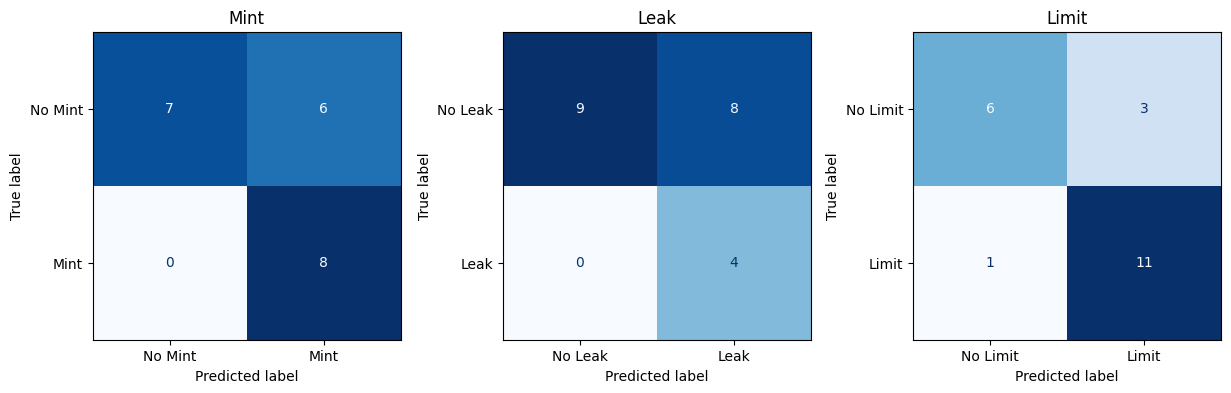

In [81]:
y_pred = tuned_gru_model.predict(ts_X_test)
thresholds, _ = tune_thresholds(ts_y_test, y_pred)

y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(ts_y_test, y_pred)

### Graph

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

#### Transaction

##### Load Data

In [83]:
graph_feature = load_feature('txn_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'txn.pkl'), 'rb'))

In [84]:
train_dataset, test_dataset = [], []
txn_graph_y_train, txn_graph_y_test = [], []
txn_graph_test_idx = []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        txn_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        txn_graph_y_test.append(y.loc[address])
        txn_graph_test_idx.append(address)

    if i < 10:
        print(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])


In [85]:
len(train_dataset), len(test_dataset)

(26, 11)

In [86]:
txn_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
txn_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [87]:
epochs = 30

In [90]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in txn_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in txn_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-29 18:38:32,044] A new study created in memory with name: no-name-3cf92afe-a228-4baa-b13a-30e8783bb23c


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:38:36,583] Trial 0 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 67, 'lr': 0.004214480107896227, 'dropout': 0.7451842413775865}. Best is trial 0 with value: 0.1818181818181818.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:01,099] Trial 1 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 211, 'lr': 0.0004105960274306184, 'dropout': 0.7607904401294789}. Best is trial 0 with value: 0.1818181818181818.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:15,848] Trial 2 finished with value: 0.0 and parameters: {'hidden_dim': 214, 'lr': 6.910734749838433e-06, 'dropout': 0.6136478374334354}. Best is trial 0 with value: 0.1818181818181818.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:30,138] Trial 3 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 234, 'lr': 3.2212522659689145e-05, 'dropout': 0.25891591122672025}. Best is trial 3 with value: 0.2222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:35,280] Trial 4 finished with value: 0.3904761904761904 and parameters: {'hidden_dim': 86, 'lr': 6.125859651554506e-05, 'dropout': 0.33939317203248154}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:42,406] Trial 5 finished with value: 0.0 and parameters: {'hidden_dim': 134, 'lr': 1.6850230859065032e-05, 'dropout': 0.4307038805992869}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:46,211] Trial 6 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 52, 'lr': 8.416316168392875e-06, 'dropout': 0.4743336960378998}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:51,273] Trial 7 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 100, 'lr': 4.753726806459595e-05, 'dropout': 0.690170537241511}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:39:58,685] Trial 8 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 101, 'lr': 0.0019001920285060365, 'dropout': 0.30734685110152427}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:40:11,305] Trial 9 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 217, 'lr': 1.5900978812727485e-05, 'dropout': 0.39668895651023023}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.3333333333333333


[I 2025-07-29 18:40:20,643] Trial 10 finished with value: 0.1851851851851852 and parameters: {'hidden_dim': 171, 'lr': 1.106061444018743e-06, 'dropout': 0.01848601412433032}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:40:30,565] Trial 11 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 164, 'lr': 0.00025280942786592487, 'dropout': 0.16906318483787755}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:40:39,431] Trial 12 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 162, 'lr': 0.0002678082554538696, 'dropout': 0.10483011693842326}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:40:47,974] Trial 13 finished with value: 0.0 and parameters: {'hidden_dim': 128, 'lr': 0.0002270908704852167, 'dropout': 0.18289613604138832}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:40:53,352] Trial 14 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 87, 'lr': 0.0008891370951713962, 'dropout': 0.1902860128306353}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:40:56,448] Trial 15 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 39, 'lr': 9.52343036806388e-05, 'dropout': 0.32767486349391023}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-29 18:41:07,482] Trial 16 finished with value: 0.0 and parameters: {'hidden_dim': 171, 'lr': 9.716652271667554e-05, 'dropout': 0.5633619275800875}. Best is trial 4 with value: 0.3904761904761904.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:41:14,031] Trial 17 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 120, 'lr': 0.0073328089643137214, 'dropout': 0.01855686179015484}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.3333333333333333


[I 2025-07-29 18:41:24,877] Trial 18 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 190, 'lr': 2.0825233578769932e-06, 'dropout': 0.14210094599229234}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:41:36,287] Trial 19 finished with value: 0.0 and parameters: {'hidden_dim': 155, 'lr': 0.0006672477203739826, 'dropout': 0.2398242973274959}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:01,340] Trial 20 finished with value: 0.0 and parameters: {'hidden_dim': 256, 'lr': 0.00015694598565142414, 'dropout': 0.3628132022206376}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:16,317] Trial 21 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 253, 'lr': 3.1056772623734416e-05, 'dropout': 0.26107141796719524}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:26,918] Trial 22 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 193, 'lr': 5.397419158171046e-05, 'dropout': 0.09318625990320603}. Best is trial 4 with value: 0.3904761904761904.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-29 18:42:30,703] Trial 23 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 72, 'lr': 2.87150239559195e-05, 'dropout': 0.4878768036136151}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:34,764] Trial 24 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 71, 'lr': 3.7932942262655548e-06, 'dropout': 0.5050650474061188}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:40,848] Trial 25 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 105, 'lr': 0.00010498953961334455, 'dropout': 0.5791081011751094}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-29 18:42:45,391] Trial 26 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 78, 'lr': 0.001627926840365622, 'dropout': 0.46277387076841797}. Best is trial 23 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:48,744] Trial 27 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 52, 'lr': 1.5459353246726106e-05, 'dropout': 0.37903107742117076}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:42:56,937] Trial 28 finished with value: 0.0 and parameters: {'hidden_dim': 144, 'lr': 0.000456349131081224, 'dropout': 0.5298195718123863}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:00,883] Trial 29 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 57, 'lr': 4.9339616857331785e-05, 'dropout': 0.31909463814453615}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:04,449] Trial 30 finished with value: 0.38181818181818183 and parameters: {'hidden_dim': 34, 'lr': 0.0013232537253446074, 'dropout': 0.69626714184462}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:07,508] Trial 31 finished with value: 0.0 and parameters: {'hidden_dim': 35, 'lr': 0.003450727380840001, 'dropout': 0.6925902317302414}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:13,498] Trial 32 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 85, 'lr': 0.0011933913484277778, 'dropout': 0.6374854751841684}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:16,758] Trial 33 finished with value: 0.0 and parameters: {'hidden_dim': 32, 'lr': 0.000389838321984156, 'dropout': 0.7395930566657876}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-29 18:43:20,684] Trial 34 finished with value: 0.0 and parameters: {'hidden_dim': 60, 'lr': 0.003256576052706236, 'dropout': 0.764663238037437}. Best is trial 23 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:24,544] Trial 35 finished with value: 0.2833333333333333 and parameters: {'hidden_dim': 68, 'lr': 0.00016602380886345498, 'dropout': 0.44019921989097605}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-29 18:43:31,011] Trial 36 finished with value: 0.0 and parameters: {'hidden_dim': 115, 'lr': 2.760993297878153e-05, 'dropout': 0.6338702689412198}. Best is trial 23 with value: 0.4222222222222222.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:33,992] Trial 37 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 48, 'lr': 7.060163188113902e-06, 'dropout': 0.21333388465865868}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:37,162] Trial 38 finished with value: 0.2169312169312169 and parameters: {'hidden_dim': 47, 'lr': 7.100088450318907e-06, 'dropout': 0.25146193708238707}. Best is trial 23 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-29 18:43:42,487] Trial 39 finished with value: 0.5416666666666666 and parameters: {'hidden_dim': 89, 'lr': 1.2898639096983569e-05, 'dropout': 0.6856715874356791}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:46,991] Trial 40 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 84, 'lr': 1.1459904762020377e-05, 'dropout': 0.7989245206965634}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-29 18:43:50,789] Trial 41 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 46, 'lr': 3.021936585601413e-06, 'dropout': 0.6873987246243274}. Best is trial 39 with value: 0.5416666666666666.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:43:56,000] Trial 42 finished with value: 0.0 and parameters: {'hidden_dim': 96, 'lr': 5.593332934995109e-06, 'dropout': 0.7151174033009454}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:00,067] Trial 43 finished with value: 0.0 and parameters: {'hidden_dim': 65, 'lr': 1.94008181841513e-05, 'dropout': 0.6023283264637618}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:04,452] Trial 44 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 76, 'lr': 1.0268961362865716e-05, 'dropout': 0.5434570706017735}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:08,008] Trial 45 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 43, 'lr': 2.31966905406663e-05, 'dropout': 0.6584177315462756}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:12,926] Trial 46 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 94, 'lr': 5.980723538813142e-05, 'dropout': 0.42395924277779934}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-29 18:44:18,979] Trial 47 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 112, 'lr': 4.9786869405202586e-06, 'dropout': 0.29420809141704485}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:22,658] Trial 48 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 62, 'lr': 3.912185183498378e-05, 'dropout': 0.34658501600454117}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:26,148] Trial 49 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 55, 'lr': 2.063583739961047e-06, 'dropout': 0.21130560454098424}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:31,125] Trial 50 finished with value: 0.1984126984126984 and parameters: {'hidden_dim': 75, 'lr': 1.3027522446913664e-05, 'dropout': 0.501457334336381}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:37,008] Trial 51 finished with value: 0.4067460317460318 and parameters: {'hidden_dim': 111, 'lr': 4.8851833514751945e-06, 'dropout': 0.2847471594425488}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:42,927] Trial 52 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 106, 'lr': 9.349486650699288e-06, 'dropout': 0.3982028493986509}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:49,720] Trial 53 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 130, 'lr': 7.613933057350943e-05, 'dropout': 0.2826734188652559}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:44:55,243] Trial 54 finished with value: 0.34722222222222215 and parameters: {'hidden_dim': 93, 'lr': 3.088197655128449e-06, 'dropout': 0.21645406135590245}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:00,500] Trial 55 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 86, 'lr': 0.009434275872513791, 'dropout': 0.13500675156887937}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:06,880] Trial 56 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 121, 'lr': 1.1659081282765943e-06, 'dropout': 0.3561738901178344}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:10,137] Trial 57 finished with value: 0.38888888888888884 and parameters: {'hidden_dim': 40, 'lr': 6.931407386341079e-06, 'dropout': 0.27289368279481074}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-29 18:45:14,394] Trial 58 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 38, 'lr': 1.9413911116849395e-05, 'dropout': 0.2746574373239823}. Best is trial 39 with value: 0.5416666666666666.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:19,075] Trial 59 finished with value: 0.0 and parameters: {'hidden_dim': 78, 'lr': 3.435195702896987e-05, 'dropout': 0.31344512683748044}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:26,678] Trial 60 finished with value: 0.23809523809523805 and parameters: {'hidden_dim': 137, 'lr': 4.711561959614954e-06, 'dropout': 0.5947969968861353}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:30,050] Trial 61 finished with value: 0.23809523809523805 and parameters: {'hidden_dim': 49, 'lr': 7.996493818615374e-06, 'dropout': 0.2139405611808993}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.2


[I 2025-07-29 18:45:33,062] Trial 62 finished with value: 0.20952380952380953 and parameters: {'hidden_dim': 32, 'lr': 2.0312467638062814e-06, 'dropout': 0.1599900584580237}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:38,639] Trial 63 finished with value: 0.0 and parameters: {'hidden_dim': 70, 'lr': 6.010098508962862e-06, 'dropout': 0.2357348181776475}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:41,600] Trial 64 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 41, 'lr': 1.6067973221998034e-05, 'dropout': 0.08569335118941199}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:46,762] Trial 65 finished with value: 0.0 and parameters: {'hidden_dim': 55, 'lr': 2.5374565599798735e-05, 'dropout': 0.2957972166721514}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:50,424] Trial 66 finished with value: 0.38888888888888884 and parameters: {'hidden_dim': 64, 'lr': 0.0001238430209807243, 'dropout': 0.3310822580473183}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:54,282] Trial 67 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 65, 'lr': 0.00011358144546571695, 'dropout': 0.3720359179505541}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:45:59,400] Trial 68 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 79, 'lr': 0.00018173662978674649, 'dropout': 0.32801119751622365}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:05,199] Trial 69 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 102, 'lr': 0.004887001638018047, 'dropout': 0.34061426612702533}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:10,453] Trial 70 finished with value: 0.2824074074074074 and parameters: {'hidden_dim': 87, 'lr': 1.281767729389928e-05, 'dropout': 0.42554463713550555}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:14,155] Trial 71 finished with value: 0.0 and parameters: {'hidden_dim': 51, 'lr': 3.0267689679973196e-06, 'dropout': 0.26750016030549817}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:17,439] Trial 72 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 43, 'lr': 7.313712092465114e-05, 'dropout': 0.2397324427876691}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:21,053] Trial 73 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 60, 'lr': 8.165240129839672e-06, 'dropout': 0.1907808085267454}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444


[I 2025-07-29 18:46:25,505] Trial 74 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 72, 'lr': 3.9305407247963275e-05, 'dropout': 0.39140816340345347}. Best is trial 39 with value: 0.5416666666666666.


Label 1: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:30,735] Trial 75 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 91, 'lr': 4.116686011449674e-05, 'dropout': 0.4106342058569379}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:36,356] Trial 76 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 70, 'lr': 0.0006127252700528711, 'dropout': 0.4799076680657156}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:41,259] Trial 77 finished with value: 0.0 and parameters: {'hidden_dim': 82, 'lr': 0.0003337010889684264, 'dropout': 0.4536525827608825}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:46,839] Trial 78 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 100, 'lr': 0.00012641747574636784, 'dropout': 0.7558129455354418}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-29 18:46:53,215] Trial 79 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 111, 'lr': 7.099195767623586e-05, 'dropout': 0.37625801062346464}. Best is trial 39 with value: 0.5416666666666666.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:46:57,892] Trial 80 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 73, 'lr': 5.320162932604706e-05, 'dropout': 0.6760328355360502}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:02,058] Trial 81 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 57, 'lr': 4.058020346690835e-06, 'dropout': 0.726854209701387}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:05,031] Trial 82 finished with value: 0.375 and parameters: {'hidden_dim': 37, 'lr': 2.3477813081621802e-05, 'dropout': 0.3038924045631127}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:07,913] Trial 83 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 35, 'lr': 2.2095900351550867e-05, 'dropout': 0.32879435219524095}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:11,630] Trial 84 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 64, 'lr': 3.8065724894971756e-05, 'dropout': 0.3853768436934335}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-29 18:47:23,916] Trial 85 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 224, 'lr': 2.7866429985204967e-05, 'dropout': 0.304412018969061}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:27,583] Trial 86 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 39, 'lr': 1.4075075438860028e-05, 'dropout': 0.3580479415125902}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:31,566] Trial 87 finished with value: 0.0 and parameters: {'hidden_dim': 53, 'lr': 0.0025180673635488053, 'dropout': 0.4032219041032009}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:38,272] Trial 88 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 90, 'lr': 0.0010626546791109017, 'dropout': 0.7859132011903498}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:42,293] Trial 89 finished with value: 0.1984126984126984 and parameters: {'hidden_dim': 46, 'lr': 1.814194045616056e-05, 'dropout': 0.6303023045973968}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:48,081] Trial 90 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 120, 'lr': 1.102767046910424e-05, 'dropout': 0.28397260405343183}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:51,723] Trial 91 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 48, 'lr': 6.3702463800299525e-06, 'dropout': 0.2603308202279109}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:55,423] Trial 92 finished with value: 0.0 and parameters: {'hidden_dim': 61, 'lr': 3.2109876724852764e-05, 'dropout': 0.3361113877115304}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:47:58,722] Trial 93 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 36, 'lr': 8.653880954731982e-05, 'dropout': 0.7061307108223295}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-29 18:48:02,401] Trial 94 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 44, 'lr': 6.0675620806643286e-05, 'dropout': 0.31007978258993574}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:48:05,409] Trial 95 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 32, 'lr': 9.603059737771422e-06, 'dropout': 0.24628138014165019}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:48:10,428] Trial 96 finished with value: 0.24603174603174602 and parameters: {'hidden_dim': 97, 'lr': 2.1580307741081533e-05, 'dropout': 0.22858176944664493}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-29 18:48:14,684] Trial 97 finished with value: 0.2074074074074074 and parameters: {'hidden_dim': 69, 'lr': 4.1922551410064394e-05, 'dropout': 0.3498203710703861}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-29 18:48:29,799] Trial 98 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 81, 'lr': 7.117326649929175e-06, 'dropout': 0.18871603371457965}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-29 18:48:34,140] Trial 99 finished with value: 0.0 and parameters: {'hidden_dim': 75, 'lr': 4.302318052528751e-06, 'dropout': 0.2913153092216836}. Best is trial 39 with value: 0.5416666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Best Params: {'hidden_dim': 89, 'lr': 1.2898639096983569e-05, 'dropout': 0.6856715874356791}
Best Score: 0.5416666666666666


##### Final

Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4
Label 2: Best threshold = 0.0, Best f1 = 0.625
              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00         3
        Leak       0.25      1.00      0.40         1
       Limit       0.00      0.00      0.00         5

   micro avg       0.17      0.11      0.13         9
   macro avg       0.08      0.33      0.13         9
weighted avg       0.03      0.11      0.04         9
 samples avg       0.09      0.05      0.06         9



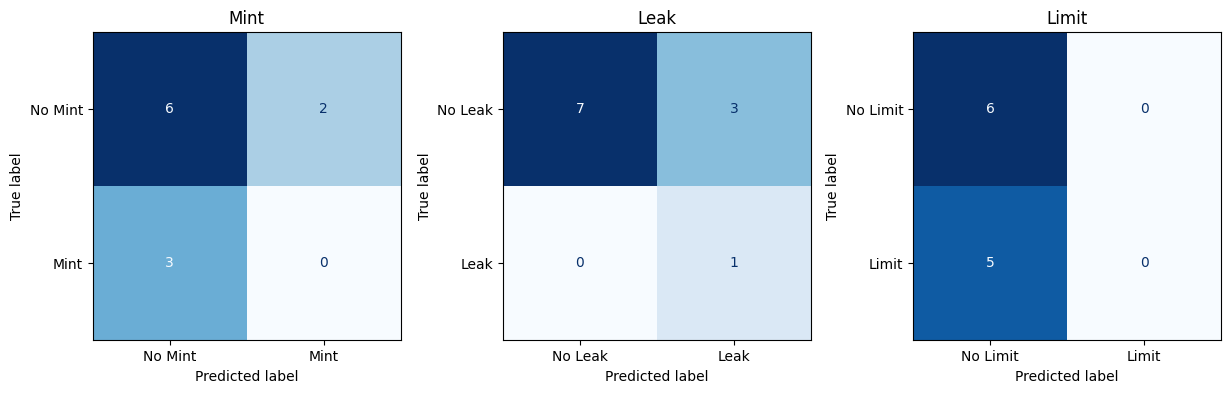

In [91]:
# Model setup
tuned_txn_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_txn_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_txn_gcn_model.train()
for epoch in range(epochs):
    for batch in txn_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_txn_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_txn_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in txn_graph_test_loader:
        out = tuned_txn_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### Control Flow

##### Load Data

In [92]:
graph_feature = load_feature('cfg_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'cfg.pkl'), 'rb'))

In [93]:
train_dataset, test_dataset = [], []
cfg_graph_y_train, cfg_graph_y_test = [], []
cfg_graph_test_idx = []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        cfg_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        cfg_graph_y_test.append(y.loc[address])
        cfg_graph_test_idx.append(address)

    if i < 10:
        print(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


In [94]:
len(train_dataset), len(test_dataset)

(47, 20)

In [95]:
cfg_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
cfg_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [96]:
epochs = 30

In [97]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in cfg_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in cfg_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-29 18:48:40,505] A new study created in memory with name: no-name-e16ec5e2-a4cb-43f8-b990-643971c403d2


Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:48:43,351] Trial 0 finished with value: 0.3111111111111111 and parameters: {'hidden_dim': 40, 'lr': 0.0010430933532576913, 'dropout': 0.09137495350660424}. Best is trial 0 with value: 0.3111111111111111.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.56
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:48:52,212] Trial 1 finished with value: 0.32952380952380955 and parameters: {'hidden_dim': 221, 'lr': 8.260719041903078e-06, 'dropout': 0.5843286969564726}. Best is trial 1 with value: 0.32952380952380955.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:48:57,684] Trial 2 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 127, 'lr': 0.0014625387909983358, 'dropout': 0.11742586975130456}. Best is trial 1 with value: 0.32952380952380955.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:07,161] Trial 3 finished with value: 0.19572649572649573 and parameters: {'hidden_dim': 230, 'lr': 3.603685101705634e-05, 'dropout': 0.2974071404467224}. Best is trial 1 with value: 0.32952380952380955.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4444444444444444


[I 2025-07-29 18:49:09,942] Trial 4 finished with value: 0.3847072879330944 and parameters: {'hidden_dim': 36, 'lr': 0.00047458327118869286, 'dropout': 0.672465115778807}. Best is trial 4 with value: 0.3847072879330944.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-29 18:49:16,979] Trial 5 finished with value: 0.30617283950617286 and parameters: {'hidden_dim': 192, 'lr': 8.625163814197035e-05, 'dropout': 0.39662090747467604}. Best is trial 4 with value: 0.3847072879330944.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:20,437] Trial 6 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 44, 'lr': 2.4019390815812213e-06, 'dropout': 0.6711834283941743}. Best is trial 6 with value: 0.4093986459577857.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:24,444] Trial 7 finished with value: 0.32746823069403713 and parameters: {'hidden_dim': 96, 'lr': 1.999625426073617e-06, 'dropout': 0.3112214208206102}. Best is trial 6 with value: 0.4093986459577857.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5555555555555556
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:28,195] Trial 8 finished with value: 0.41595441595441596 and parameters: {'hidden_dim': 88, 'lr': 2.155122173208718e-05, 'dropout': 0.28677851006207117}. Best is trial 8 with value: 0.41595441595441596.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:49:32,166] Trial 9 finished with value: 0.1952380952380952 and parameters: {'hidden_dim': 62, 'lr': 1.2483779935498617e-06, 'dropout': 0.5427976591705846}. Best is trial 8 with value: 0.41595441595441596.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:38,354] Trial 10 finished with value: 0.2594268476621418 and parameters: {'hidden_dim': 161, 'lr': 0.009623176349815165, 'dropout': 0.005633578836139463}. Best is trial 8 with value: 0.41595441595441596.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:42,544] Trial 11 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 88, 'lr': 1.1232316861093643e-05, 'dropout': 0.7710349437410507}. Best is trial 8 with value: 0.41595441595441596.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:46,793] Trial 12 finished with value: 0.4868491680085883 and parameters: {'hidden_dim': 90, 'lr': 6.3943954097927855e-06, 'dropout': 0.24179476095237573}. Best is trial 12 with value: 0.4868491680085883.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:49:51,643] Trial 13 finished with value: 0.2371794871794872 and parameters: {'hidden_dim': 122, 'lr': 1.2980546461194301e-05, 'dropout': 0.21348457905019155}. Best is trial 12 with value: 0.4868491680085883.


Label 1: Best threshold = 0.01, Best f1 = 0.46153846153846156
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:49:56,174] Trial 14 finished with value: 0.3141025641025641 and parameters: {'hidden_dim': 84, 'lr': 4.4924765197170044e-05, 'dropout': 0.4304743754372733}. Best is trial 12 with value: 0.4868491680085883.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5833333333333334
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:02,031] Trial 15 finished with value: 0.3277777777777778 and parameters: {'hidden_dim': 153, 'lr': 0.00020272017606944888, 'dropout': 0.21051496171142206}. Best is trial 12 with value: 0.4868491680085883.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173


[I 2025-07-29 18:50:06,752] Trial 16 finished with value: 0.28878153515834676 and parameters: {'hidden_dim': 116, 'lr': 5.06930593367473e-06, 'dropout': 0.4032316335114309}. Best is trial 12 with value: 0.4868491680085883.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:50:10,857] Trial 17 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 74, 'lr': 2.3862356189899623e-05, 'dropout': 0.25333395801587144}. Best is trial 12 with value: 0.4868491680085883.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.56
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:15,067] Trial 18 finished with value: 0.42322580645161295 and parameters: {'hidden_dim': 97, 'lr': 3.4252003919411507e-06, 'dropout': 0.13839014045510833}. Best is trial 12 with value: 0.4868491680085883.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:22,880] Trial 19 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 183, 'lr': 3.6928067821816596e-06, 'dropout': 0.13002990342970003}. Best is trial 12 with value: 0.4868491680085883.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-29 18:50:27,532] Trial 20 finished with value: 0.4969501781095984 and parameters: {'hidden_dim': 111, 'lr': 1.2279863597177589e-06, 'dropout': 0.04907699512239702}. Best is trial 20 with value: 0.4969501781095984.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:32,350] Trial 21 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 109, 'lr': 4.443075906896363e-06, 'dropout': 0.01610650701098209}. Best is trial 20 with value: 0.4969501781095984.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:38,111] Trial 22 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 133, 'lr': 1.146100023486527e-06, 'dropout': 0.16320614512731182}. Best is trial 20 with value: 0.4969501781095984.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:42,496] Trial 23 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 105, 'lr': 1.1845389711106912e-06, 'dropout': 0.05811142967263781}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:50:46,630] Trial 24 finished with value: 0.4217443249701314 and parameters: {'hidden_dim': 61, 'lr': 1.0651791462187295e-06, 'dropout': 0.07336280379197074}. Best is trial 23 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.8333333333333334
Label 1: Best threshold = 0.01, Best f1 = 0.4
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:50:52,103] Trial 25 finished with value: 0.41111111111111115 and parameters: {'hidden_dim': 146, 'lr': 7.197659066105085e-06, 'dropout': 0.051154342709242843}. Best is trial 23 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:50:56,653] Trial 26 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 106, 'lr': 2.225582944965751e-06, 'dropout': 0.17663836291778143}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:00,720] Trial 27 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 68, 'lr': 1.0175367310608792e-06, 'dropout': 0.3617646640399987}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:06,929] Trial 28 finished with value: 0.3047619047619048 and parameters: {'hidden_dim': 166, 'lr': 2.5271559290741817e-06, 'dropout': 0.04696907302779237}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.01, Best f1 = 0.7142857142857143
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:13,055] Trial 29 finished with value: 0.21666666666666667 and parameters: {'hidden_dim': 139, 'lr': 1.5933306231212803e-05, 'dropout': 0.10305465490579185}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:51:17,503] Trial 30 finished with value: 0.32499999999999996 and parameters: {'hidden_dim': 107, 'lr': 6.051154317480093e-06, 'dropout': 0.47655771854448015}. Best is trial 23 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:22,036] Trial 31 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 101, 'lr': 3.407018339500329e-06, 'dropout': 0.13995739423979847}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:26,128] Trial 32 finished with value: 0.0 and parameters: {'hidden_dim': 80, 'lr': 1.952156658847943e-06, 'dropout': 0.21404495475319746}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:51:31,471] Trial 33 finished with value: 0.2940516273849607 and parameters: {'hidden_dim': 120, 'lr': 8.490703675139601e-06, 'dropout': 0.09034808893590995}. Best is trial 23 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:41,988] Trial 34 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 249, 'lr': 1.6978811580843777e-06, 'dropout': 0.1704913534355335}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:44,855] Trial 35 finished with value: 0.24691358024691357 and parameters: {'hidden_dim': 48, 'lr': 0.0015884381167063193, 'dropout': 0.0014331192228863449}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.01, Best f1 = 0.7407407407407407
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:51:50,858] Trial 36 finished with value: 0.2174688057040998 and parameters: {'hidden_dim': 130, 'lr': 7.632573047280263e-05, 'dropout': 0.09670078605296628}. Best is trial 23 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:51:54,058] Trial 37 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 57, 'lr': 3.274018044515002e-06, 'dropout': 0.3380810538323355}. Best is trial 23 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:51:58,138] Trial 38 finished with value: 0.0 and parameters: {'hidden_dim': 91, 'lr': 0.00021907874853547126, 'dropout': 0.2768976468589986}. Best is trial 23 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173
Label 2: Best threshold = 0.01, Best f1 = 0.7586206896551724


[I 2025-07-29 18:52:03,497] Trial 39 finished with value: 0.5416550983767375 and parameters: {'hidden_dim': 114, 'lr': 6.49349245102591e-06, 'dropout': 0.047680856199372415}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:10,113] Trial 40 finished with value: 0.3803418803418803 and parameters: {'hidden_dim': 180, 'lr': 3.13070154692862e-05, 'dropout': 0.06512451803947632}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:15,477] Trial 41 finished with value: 0.24444444444444446 and parameters: {'hidden_dim': 114, 'lr': 8.451605721887459e-06, 'dropout': 0.0471785333032545}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:19,380] Trial 42 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 96, 'lr': 1.754088157136552e-06, 'dropout': 0.12250802881306248}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:22,943] Trial 43 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 74, 'lr': 1.582380601261838e-06, 'dropout': 0.03371742436985637}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:28,490] Trial 44 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 123, 'lr': 1.6191647731866633e-06, 'dropout': 0.11076933611275856}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:32,627] Trial 45 finished with value: 0.15384615384615385 and parameters: {'hidden_dim': 98, 'lr': 2.5538084049751878e-06, 'dropout': 0.2436839829080213}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:38,594] Trial 46 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 137, 'lr': 5.310446159104537e-06, 'dropout': 0.1925969450948605}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4444444444444444


[I 2025-07-29 18:52:42,589] Trial 47 finished with value: 0.2884990253411306 and parameters: {'hidden_dim': 83, 'lr': 1.1791297591527632e-05, 'dropout': 0.0771455998255019}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.8333333333333334


[I 2025-07-29 18:52:48,191] Trial 48 finished with value: 0.4047619047619048 and parameters: {'hidden_dim': 152, 'lr': 4.689224890179847e-05, 'dropout': 0.13825821590699472}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5714285714285714


[I 2025-07-29 18:52:53,011] Trial 49 finished with value: 0.35714285714285715 and parameters: {'hidden_dim': 93, 'lr': 0.006577564493889823, 'dropout': 0.23086653537834967}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:52:56,146] Trial 50 finished with value: 0.26495726495726496 and parameters: {'hidden_dim': 50, 'lr': 1.7646957576288892e-05, 'dropout': 0.5971681459159899}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:53:00,506] Trial 51 finished with value: 0.2921146953405018 and parameters: {'hidden_dim': 102, 'lr': 3.4509975504108803e-06, 'dropout': 0.134175899995301}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:05,810] Trial 52 finished with value: 0.3055555555555555 and parameters: {'hidden_dim': 116, 'lr': 1.5158245118450382e-06, 'dropout': 0.02232052819329748}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:09,479] Trial 53 finished with value: 0.15384615384615385 and parameters: {'hidden_dim': 76, 'lr': 2.6130667164120756e-06, 'dropout': 0.1522376863825974}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.01, Best f1 = 0.7586206896551724


[I 2025-07-29 18:53:13,605] Trial 54 finished with value: 0.2528735632183908 and parameters: {'hidden_dim': 91, 'lr': 4.307876932609913e-06, 'dropout': 0.11671342836098389}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:19,359] Trial 55 finished with value: 0.2810035842293907 and parameters: {'hidden_dim': 129, 'lr': 1.3129316962284996e-06, 'dropout': 0.07583197593574773}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.7142857142857143
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:23,649] Trial 56 finished with value: 0.3784461152882206 and parameters: {'hidden_dim': 112, 'lr': 9.488589635813438e-06, 'dropout': 0.18313798717997049}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:27,274] Trial 57 finished with value: 0.5076702508960573 and parameters: {'hidden_dim': 67, 'lr': 6.0785082571787715e-06, 'dropout': 0.7891997937531622}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:53:30,775] Trial 58 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 40, 'lr': 5.5505442736881935e-06, 'dropout': 0.756175221733119}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:34,777] Trial 59 finished with value: 0.3698924731182796 and parameters: {'hidden_dim': 85, 'lr': 2.3175053387036298e-06, 'dropout': 0.6015370002272957}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:38,159] Trial 60 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 68, 'lr': 6.993007437737995e-06, 'dropout': 0.715770795013128}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:43,030] Trial 61 finished with value: 0.39040529363110005 and parameters: {'hidden_dim': 98, 'lr': 1.0988661800198037e-06, 'dropout': 0.5456009469298059}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:53:46,477] Trial 62 finished with value: 0.21212121212121213 and parameters: {'hidden_dim': 68, 'lr': 3.2759574457042763e-06, 'dropout': 0.00016651648501447847}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:51,063] Trial 63 finished with value: 0.32746823069403713 and parameters: {'hidden_dim': 105, 'lr': 3.818120460534874e-06, 'dropout': 0.47207533837544813}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173


[I 2025-07-29 18:53:56,714] Trial 64 finished with value: 0.19927536231884058 and parameters: {'hidden_dim': 125, 'lr': 2.0587728935640684e-06, 'dropout': 0.6546337763066727}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:53:59,987] Trial 65 finished with value: 0.24444444444444446 and parameters: {'hidden_dim': 59, 'lr': 1.2875287453451392e-05, 'dropout': 0.0368136106911706}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:03,803] Trial 66 finished with value: 0.32746823069403713 and parameters: {'hidden_dim': 78, 'lr': 4.685870363467744e-06, 'dropout': 0.2675303022638668}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:07,277] Trial 67 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 34, 'lr': 2.6878810468108708e-06, 'dropout': 0.31709324138241457}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:11,156] Trial 68 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 96, 'lr': 1.0210670429647304e-06, 'dropout': 0.06432316607637156}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:54:15,578] Trial 69 finished with value: 0.3134920634920635 and parameters: {'hidden_dim': 106, 'lr': 1.4470157514862244e-06, 'dropout': 0.09947128485016346}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:19,991] Trial 70 finished with value: 0.4587813620071685 and parameters: {'hidden_dim': 88, 'lr': 6.804274077063481e-06, 'dropout': 0.16091010699481648}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:54:23,654] Trial 71 finished with value: 0.1717171717171717 and parameters: {'hidden_dim': 88, 'lr': 7.088965895550175e-06, 'dropout': 0.2052229321482729}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.7692307692307693
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:54:28,188] Trial 72 finished with value: 0.5135531135531136 and parameters: {'hidden_dim': 118, 'lr': 1.567206727846049e-05, 'dropout': 0.12151409190709259}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:33,489] Trial 73 finished with value: 0.19393939393939394 and parameters: {'hidden_dim': 117, 'lr': 1.012665833736204e-05, 'dropout': 0.15252031661165685}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:37,924] Trial 74 finished with value: 0.24444444444444446 and parameters: {'hidden_dim': 109, 'lr': 2.1960901940282128e-05, 'dropout': 0.12381191926686189}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:44,119] Trial 75 finished with value: 0.30462184873949577 and parameters: {'hidden_dim': 143, 'lr': 1.530401955849333e-05, 'dropout': 0.08646884482708513}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6


[I 2025-07-29 18:54:48,776] Trial 76 finished with value: 0.2740740740740741 and parameters: {'hidden_dim': 122, 'lr': 6.19580281142948e-06, 'dropout': 0.055245878520413884}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:52,246] Trial 77 finished with value: 0.23604465709728864 and parameters: {'hidden_dim': 70, 'lr': 2.5370521715964385e-05, 'dropout': 0.1627631225571701}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:54:56,769] Trial 78 finished with value: 0.3115942028985507 and parameters: {'hidden_dim': 85, 'lr': 0.00019840198788744206, 'dropout': 0.023295773390200048}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-29 18:55:01,864] Trial 79 finished with value: 0.20454545454545456 and parameters: {'hidden_dim': 133, 'lr': 4.2468179590596484e-05, 'dropout': 0.40603877448564984}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:55:05,723] Trial 80 finished with value: 0.37346390168970817 and parameters: {'hidden_dim': 92, 'lr': 1.9140406339622922e-06, 'dropout': 0.11347407983002909}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.8333333333333334
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:55:10,701] Trial 81 finished with value: 0.3888888888888889 and parameters: {'hidden_dim': 101, 'lr': 4.58287779449799e-06, 'dropout': 0.18677643810713374}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:55:15,489] Trial 82 finished with value: 0.2828282828282828 and parameters: {'hidden_dim': 112, 'lr': 2.891575704092045e-06, 'dropout': 0.09532382159249779}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:55:19,708] Trial 83 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 81, 'lr': 8.520884327156228e-06, 'dropout': 0.14497069751238462}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-29 18:55:27,996] Trial 84 finished with value: 0.530610767169907 and parameters: {'hidden_dim': 216, 'lr': 1.9224753561165278e-06, 'dropout': 0.7987901434719318}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:55:36,158] Trial 85 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 201, 'lr': 1.3873492752090638e-06, 'dropout': 0.7906588539725715}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:55:42,129] Trial 86 finished with value: 0.19444444444444442 and parameters: {'hidden_dim': 163, 'lr': 1.9113341993934158e-06, 'dropout': 0.7029580852551748}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:55:51,090] Trial 87 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 219, 'lr': 1.6530447703745048e-05, 'dropout': 0.7684193805638032}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-29 18:55:59,946] Trial 88 finished with value: 0.3216374269005848 and parameters: {'hidden_dim': 220, 'lr': 4.246228732264337e-06, 'dropout': 0.7968153571645565}. Best is trial 39 with value: 0.5416550983767375.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:05,618] Trial 89 finished with value: 0.4868491680085883 and parameters: {'hidden_dim': 152, 'lr': 6.108330629818137e-05, 'dropout': 0.7515486935617305}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:15,717] Trial 90 finished with value: 0.20634920634920637 and parameters: {'hidden_dim': 246, 'lr': 6.508544160306749e-05, 'dropout': 0.7320700241152034}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:22,230] Trial 91 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 173, 'lr': 0.00011525824829635735, 'dropout': 0.7463806455706099}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:30,535] Trial 92 finished with value: 0.19444444444444442 and parameters: {'hidden_dim': 199, 'lr': 0.00013823681198048225, 'dropout': 0.6898271163409643}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:37,268] Trial 93 finished with value: 0.0784313725490196 and parameters: {'hidden_dim': 154, 'lr': 0.0003806818538132093, 'dropout': 0.7830988532023818}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:46,026] Trial 94 finished with value: 0.2014652014652015 and parameters: {'hidden_dim': 229, 'lr': 2.7790229297520624e-05, 'dropout': 0.7349750943831942}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-29 18:56:49,880] Trial 95 finished with value: 0.38888888888888884 and parameters: {'hidden_dim': 54, 'lr': 1.2461362123796394e-06, 'dropout': 0.04347092971988688}. Best is trial 39 with value: 0.5416550983767375.


Label 1: Best threshold = 0.01, Best f1 = 0.38095238095238093
Label 2: Best threshold = 0.01, Best f1 = 0.7857142857142857
Label 0: Best threshold = 0.01, Best f1 = 0.5217391304347826
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:56:54,411] Trial 96 finished with value: 0.28502415458937197 and parameters: {'hidden_dim': 103, 'lr': 5.819345341515051e-06, 'dropout': 0.771306349564978}. Best is trial 39 with value: 0.5416550983767375.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.7692307692307693
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:57:00,112] Trial 97 finished with value: 0.5714007687442223 and parameters: {'hidden_dim': 119, 'lr': 1.0686536956606373e-05, 'dropout': 0.6361365049122194}. Best is trial 97 with value: 0.5714007687442223.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:57:06,077] Trial 98 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 135, 'lr': 2.0066558588049212e-05, 'dropout': 0.6701168876589297}. Best is trial 97 with value: 0.5714007687442223.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-29 18:57:10,991] Trial 99 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 119, 'lr': 1.0529593696560733e-05, 'dropout': 0.6372221887595755}. Best is trial 97 with value: 0.5714007687442223.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Best Params: {'hidden_dim': 119, 'lr': 1.0686536956606373e-05, 'dropout': 0.6361365049122194}
Best Score: 0.5714007687442223


##### Final

Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.01, Best f1 = 0.7586206896551724
              precision    recall  f1-score   support

        Mint       0.22      0.29      0.25         7
        Leak       0.00      0.00      0.00         4
       Limit       0.61      1.00      0.76        11

   micro avg       0.48      0.59      0.53        22
   macro avg       0.28      0.43      0.34        22
weighted avg       0.38      0.59      0.46        22
 samples avg       0.50      0.42      0.43        22



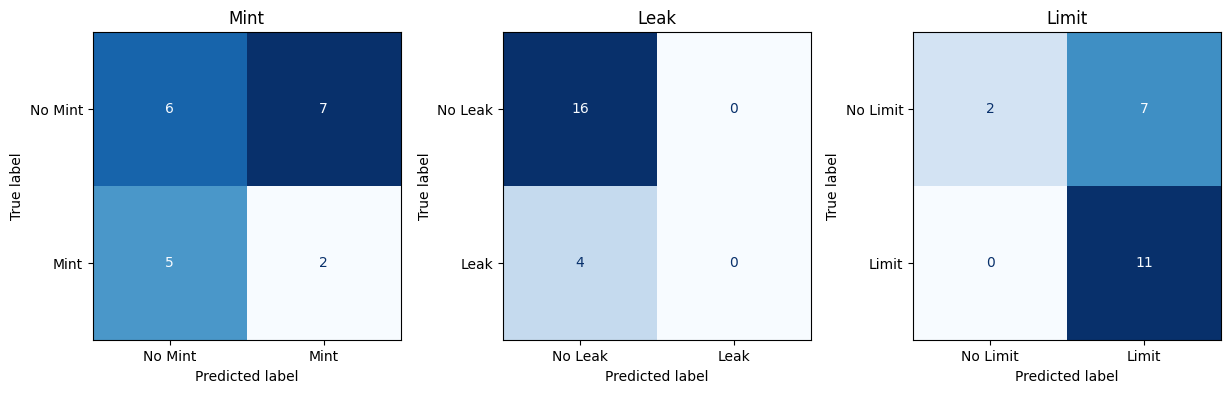

In [98]:
# Model setup
tuned_cfg_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_cfg_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_cfg_gcn_model.train()
for epoch in range(epochs):
    for batch in cfg_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_cfg_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_cfg_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in cfg_graph_test_loader:
        out = tuned_cfg_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

## Fusion

### Track Which Model Can Predict Which Address

In [99]:
def predict(model, loader, thresholds=None):
    model.eval()
    y_true, y_probs, y_preds = [], [], []

    with torch.no_grad():
        for batch in loader:
            out = torch.sigmoid(model(batch))
            y_probs.append(out.cpu())
            y_true.append(batch.y.cpu())

    y_probs = torch.cat(y_probs).numpy()
    y_true = torch.cat(y_true).numpy()

    if thresholds is not None:
        y_preds = (y_probs > thresholds).astype(int)
    else:
        best_thresholds, _ = tune_thresholds(y_true, y_probs)
        y_preds = (y_probs > best_thresholds).astype(int)

    return y_true, y_preds, y_probs

In [100]:
# For each model, create a dict of predictions and a set of supported addresses
available_preds = {}
available_prob = {}
available_y_true = {}
B_weights = {}
C_weights = {}

for model_name, model_obj, test_idx, X_test, y_test in [
    ("txn", tuned_txn_model, txn_test_idx, txn_X_test, txn_y_test),
    ("byte", tuned_byte_model, byte_test_idx, byte_X_test, byte_y_test),
    ("source", tuned_source_model, source_test_idx, source_X_test, source_y_test),
    ("timeseries", tuned_gru_model, ts_test_idx, ts_X_test, ts_y_test),
    ("txn_gcn", tuned_txn_gcn_model, txn_graph_test_idx, txn_graph_test_loader, txn_graph_y_test),
    ("cfg_gcn", tuned_cfg_gcn_model, cfg_graph_test_idx, cfg_graph_test_loader, cfg_graph_y_test)
]:
    print(f"Predicting {model_name}...")
    if model_name in ['txn_gcn', 'cfg_gcn']:
        _, y_pred, prob = predict(model_obj, X_test)
    else:
        y_pred = model_obj.predict(X_test)

        if model_name == 'timeseries':
            thresholds, _ = tune_thresholds(y_test, y_pred)
            prob = y_pred
            y_pred = (y_pred > thresholds).astype(int)
        else:
            proba = model_obj.predict_proba(X_test)
            prob = np.array([p[:, 1] for p in proba]).T  # shape: [n_samples, n_labels]

    available_prob[model_name] = {addr: prob for addr, prob in zip(test_idx, prob)}
    available_preds[model_name] = {addr: pred for addr, pred in zip(test_idx, y_pred)}
    y_test = np.array(y_test)
    available_y_true[model_name] = {addr: y for addr, y in zip(test_idx, y_test)}
    # avg weights
    B_weights[model_name] = f1_score(y_test, y_pred, average='macro')
    # per-lab weights
    C_weights[model_name] = f1_score(y_test, y_pred, average=None)

Predicting txn...
Predicting byte...
Predicting source...
Predicting timeseries...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.06, Best f1 = 0.5
Label 2: Best threshold = 0.2, Best f1 = 0.8461538461538461
Predicting txn_gcn...
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.46, Best f1 = 0.4
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Predicting cfg_gcn...
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.79, Best f1 = 0.8


In [101]:
B_weights

{'txn': 0.4488152749022314,
 'byte': 0.6126984126984127,
 'source': 0.6295739348370927,
 'timeseries': 0.6911421911421911,
 'txn_gcn': 0.4984126984126984,
 'cfg_gcn': 0.5506172839506173}

In [102]:
C_weights

{'txn': array([0.22222222, 0.42857143, 0.69565217]),
 'byte': array([0.57142857, 0.66666667, 0.6       ]),
 'source': array([0.85714286, 0.4       , 0.63157895]),
 'timeseries': array([0.72727273, 0.5       , 0.84615385]),
 'txn_gcn': array([0.42857143, 0.4       , 0.66666667]),
 'cfg_gcn': array([0.51851852, 0.33333333, 0.8       ])}

In [103]:
available_preds_df = pd.DataFrame(available_preds)
available_preds_df

,txn,byte,source,timeseries,txn_gcn,cfg_gcn
0x186ed770eecea82def7c92dcc077c4ba27acd5bd,"[1, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 0, 1]","[1, 0, 0]","[1, 1, 0]"
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"[0, 1, 1]","[0, 0, 0]",NaN,"[1, 1, 1]",NaN,NaN
0x16dfb898cf7029303c2376031392cb9bac450f94,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 1, 0]","[1, 1, 1]","[1, 1, 0]"
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"[0, 0, 0]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 1, 1]"
0xb504035a11e672e12a099f32b1672b9c4a78b22f,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[1, 1, 1]"
0x52e4339b4b9ff254738d6e971e83440f60dc029c,"[0, 1, 1]","[1, 0, 0]","[1, 0, 0]","[1, 1, 1]",NaN,"[1, 1, 1]"
0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc,"[0, 1, 1]","[0, 0, 1]","[0, 0, 1]","[1, 1, 1]",NaN,"[1, 1, 1]"
0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d,"[0, 1, 1]","[0, 1, 0]","[0, 0, 1]","[1, 1, 1]",NaN,"[1, 1, 1]"
0xaaf8c293ed36989d1871d2310b2845450d885673,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 1, 1]","[1, 1, 0]"
0x1e4402fa427a7a835fc64ea6d051404ce767a569,"[0, 1, 1]","[1, 1, 1]","[0, 0, 1]","[1, 1, 1]",NaN,"[1, 1, 1]"


In [104]:
available_y_true_df = pd.DataFrame(available_y_true)
available_y_true_df

,txn,byte,source,timeseries,txn_gcn,cfg_gcn
0x186ed770eecea82def7c92dcc077c4ba27acd5bd,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]"
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"[1, 0, 1]","[1, 0, 1]",NaN,"[1, 0, 1]",NaN,NaN
0x16dfb898cf7029303c2376031392cb9bac450f94,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]"
0xb504035a11e672e12a099f32b1672b9c4a78b22f,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x52e4339b4b9ff254738d6e971e83440f60dc029c,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]",NaN,"[1, 0, 1]"
0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc,"[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]",NaN,"[0, 0, 1]"
0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d,"[0, 1, 1]","[0, 1, 1]","[0, 1, 1]","[0, 1, 1]",NaN,"[0, 1, 1]"
0xaaf8c293ed36989d1871d2310b2845450d885673,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x1e4402fa427a7a835fc64ea6d051404ce767a569,"[0, 1, 1]","[0, 1, 1]","[0, 1, 1]","[0, 1, 1]",NaN,"[0, 1, 1]"


### Option A: Majority Voting

In [105]:
from collections import defaultdict, Counter

A_final_preds = {}
for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    label_votes = []
    for model_name, preds in available_preds.items():
        if addr in preds:
            label_votes.append(preds[addr])

    # Majority vote across models
    if label_votes:
        # Convert to array and round mean for voting
        fused = np.round(np.mean(label_votes, axis=0)).astype(int)
        A_final_preds[addr] = fused


In [106]:
A_final_preds['0x186ed770eecea82def7c92dcc077c4ba27acd5bd'], A_final_preds['0x93023f1d3525e273f291b6f76d2f5027a39bf302']

(array([1, 0, 0]), array([0, 1, 1]))

              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       0.30      0.75      0.43         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.63      0.79      0.70        24
   macro avg       0.64      0.79      0.68        24
weighted avg       0.72      0.79      0.74        24
 samples avg       0.45      0.55      0.47        24



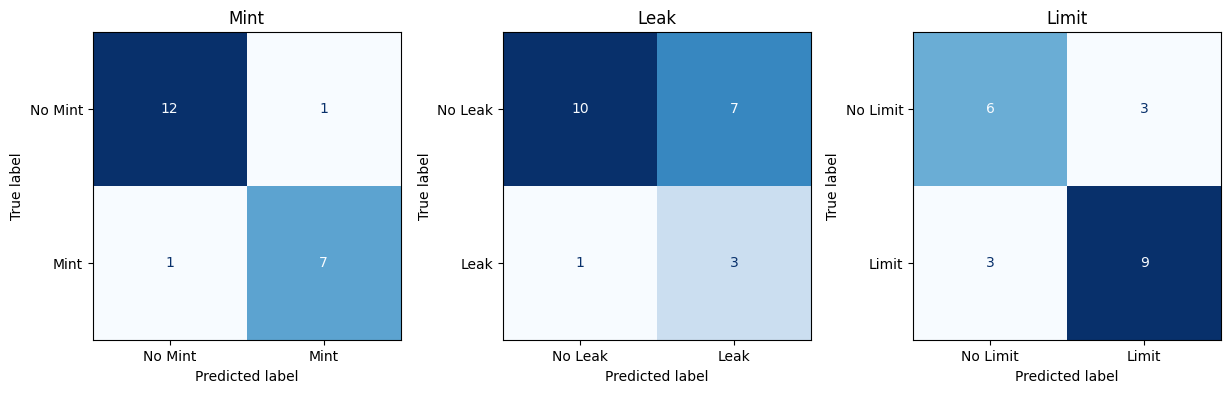

In [107]:
# Build y_true and y_pred from common addresses
common_addrs = list(A_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([A_final_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)

### Option B: Weighted Averaging

In [108]:
def objective(trial):
    thresholds = np.array([
        trial.suggest_float(f"thresh_{label}", 0.3, 0.9)
        for label in label_cols
    ])

    y_pred = (y_probs > thresholds).astype(int)
    score = f1_score(y_true, y_pred, average='macro')
    return score


In [109]:
B_final_preds = {}
B_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = 0

    for model_name, preds in available_preds.items():
        if addr in preds:
            weighted_sum += B_weights[model_name] * preds[addr]
            total_weight += B_weights[model_name]

    fused_probs = weighted_sum / total_weight
    fused = fused_probs > 0.6
    B_probs[addr] = fused_probs
    B_final_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       0.75      0.75      0.75         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.81      0.71      0.76        24
   macro avg       0.80      0.74      0.76        24
weighted avg       0.81      0.71      0.75        24
 samples avg       0.56      0.51      0.51        24



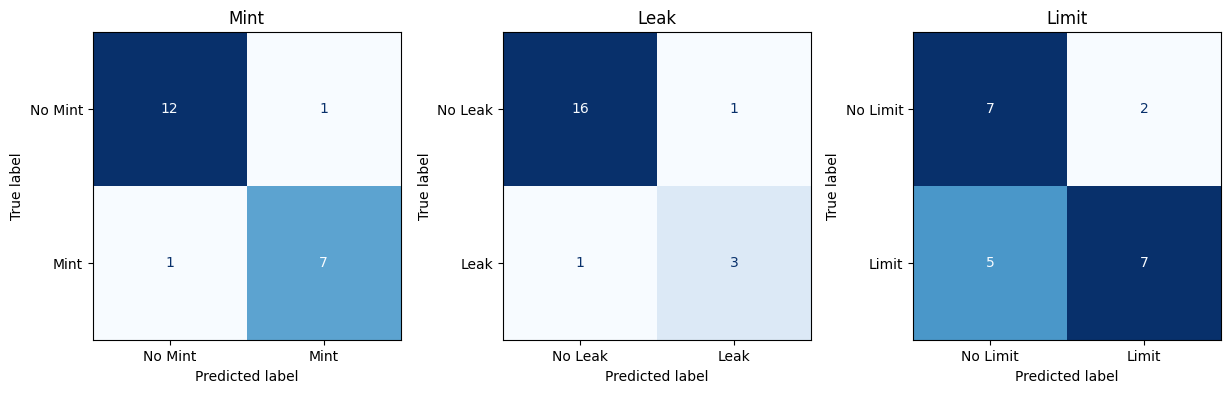

In [110]:
# Build y_true and y_pred from common addresses
common_addrs = list(B_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([B_final_preds[addr] for addr in common_addrs])
y_probs = np.array([B_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [111]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-29 18:57:20,007] A new study created in memory with name: no-name-67a55f4f-f61e-4c8d-9273-766c74114141
[I 2025-07-29 18:57:20,014] Trial 0 finished with value: 0.6709401709401709 and parameters: {'thresh_Mint': 0.33141449062026807, 'thresh_Leak': 0.3062735492650894, 'thresh_Limit': 0.4596594669974188}. Best is trial 0 with value: 0.6709401709401709.
[I 2025-07-29 18:57:20,018] Trial 1 finished with value: 0.7051282051282052 and parameters: {'thresh_Mint': 0.6398893297511437, 'thresh_Leak': 0.44523139168038983, 'thresh_Limit': 0.45440868956894565}. Best is trial 1 with value: 0.7051282051282052.
[I 2025-07-29 18:57:20,022] Trial 2 finished with value: 0.6709401709401709 and parameters: {'thresh_Mint': 0.32846636299672105, 'thresh_Leak': 0.3818377164615939, 'thresh_Limit': 0.35673129686642735}. Best is trial 1 with value: 0.7051282051282052.
[I 2025-07-29 18:57:20,027] Trial 3 finished with value: 0.5583333333333333 and parameters: {'thresh_Mint': 0.5321705634347209, 'thresh_L

Best Thresholds: [0.63481804 0.77912264 0.38086475]


              precision    recall  f1-score   support

        Mint       1.00      0.88      0.93         8
        Leak       1.00      0.75      0.86         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.88      0.88      0.88        24
   macro avg       0.93      0.85      0.88        24
weighted avg       0.89      0.88      0.88        24
 samples avg       0.62      0.60      0.59        24



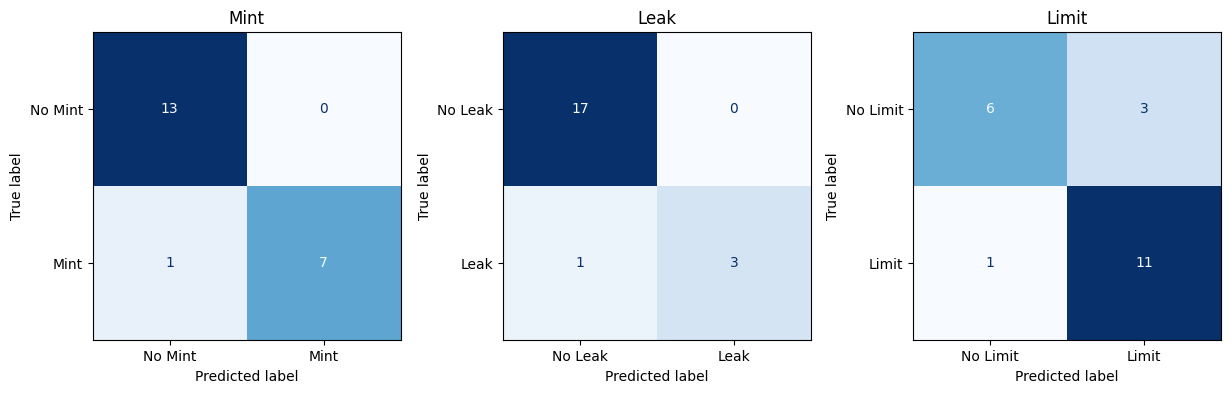

In [112]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

### Option C: Per-label weight

In [113]:
C_final_preds = {}
C_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))  # per-label weights

    for model_name, preds in available_preds.items():
        if addr in preds:
            model_weights = np.array(C_weights[model_name])
            prediction = np.array(preds[addr])

            weighted_sum += model_weights * prediction
            total_weight += model_weights

    fused_probs = (weighted_sum / np.maximum(total_weight, 1e-8))
    fused = fused_probs > 0.6
    C_probs[addr] = fused_probs
    C_final_preds[addr] = fused.astype(int)

              precision    recall  f1-score   support

        Mint       0.86      0.75      0.80         8
        Leak       1.00      0.75      0.86         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.82      0.75      0.78        24
   macro avg       0.87      0.75      0.80        24
weighted avg       0.83      0.75      0.78        24
 samples avg       0.51      0.52      0.50        24



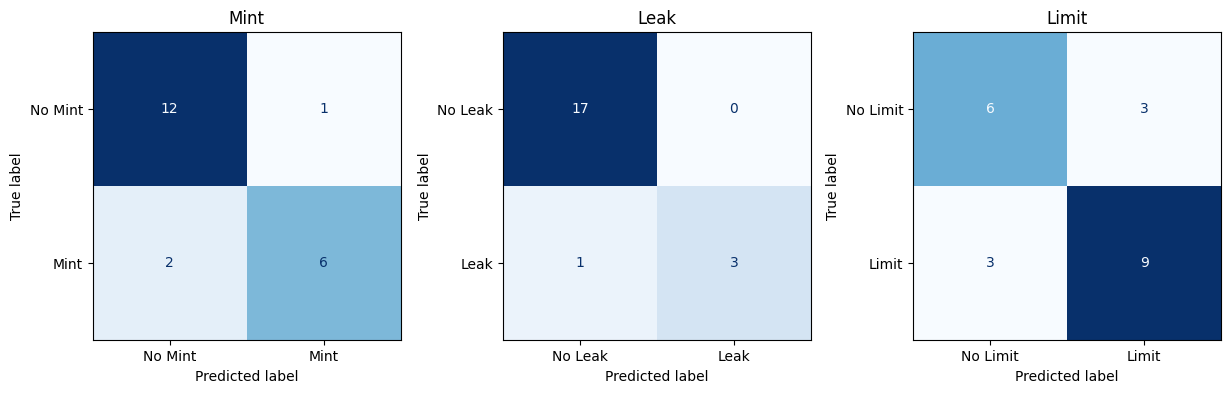

In [114]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_final_preds[addr] for addr in common_addrs])
y_probs = np.array([C_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [115]:
C_final_preds

{'0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7': array([1, 1, 1]),
 '0x10f6f2b97f3ab29583d9d38babf2994df7220c21': array([1, 0, 1]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([1, 0, 1]),
 '0x82902c20c5826984588dcd2dfcc322e05dcc435c': array([0, 0, 1]),
 '0x93023f1d3525e273f291b6f76d2f5027a39bf302': array([0, 0, 1]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([1, 0, 1]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([1, 1, 1]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 1]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 1]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([0, 0, 0]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([0, 0, 0]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([1, 0, 1]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0xd217dc0cab1c952a7ce6f4d7ca4549cde1f37bb0': array([1, 0, 0]),
 '0x11cbc781dadaad13fc3a3

In [116]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-29 18:57:22,274] A new study created in memory with name: no-name-6478e550-565c-4717-9544-bb71bd622123
[I 2025-07-29 18:57:22,279] Trial 0 finished with value: 0.78998778998779 and parameters: {'thresh_Mint': 0.8200003524363337, 'thresh_Leak': 0.6565403460847773, 'thresh_Limit': 0.4308768468664559}. Best is trial 0 with value: 0.78998778998779.
[I 2025-07-29 18:57:22,284] Trial 1 finished with value: 0.7153846153846154 and parameters: {'thresh_Mint': 0.6205702248459275, 'thresh_Leak': 0.3917998305461249, 'thresh_Limit': 0.44774333443628944}. Best is trial 0 with value: 0.78998778998779.
[I 2025-07-29 18:57:22,288] Trial 2 finished with value: 0.6944444444444443 and parameters: {'thresh_Mint': 0.7790216601324671, 'thresh_Leak': 0.8236984038305226, 'thresh_Limit': 0.562542304625406}. Best is trial 0 with value: 0.78998778998779.
[I 2025-07-29 18:57:22,293] Trial 3 finished with value: 0.5742296918767508 and parameters: {'thresh_Mint': 0.5327572908171114, 'thresh_Leak': 0.50936

Best Thresholds: [0.56139359 0.58406346 0.32501337]


              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       1.00      0.75      0.86         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.84      0.88      0.86        24
   macro avg       0.89      0.85      0.86        24
weighted avg       0.85      0.88      0.86        24
 samples avg       0.60      0.60      0.58        24



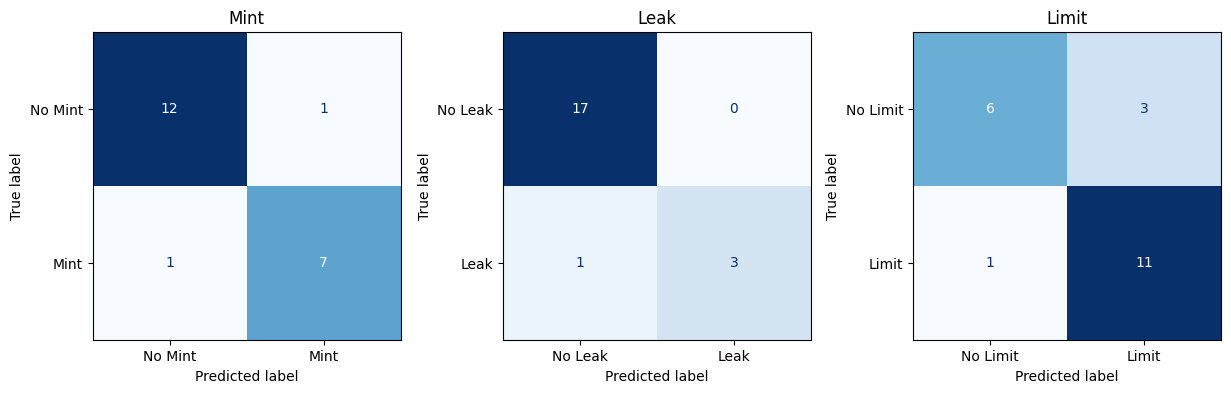

In [117]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

### Option D: Stacking

In [118]:
meta_features = []
meta_targets = []
meta_addresses = []

for addr in set.intersection(*[set(preds.keys()) for preds in available_prob.values()]):  # Only common addresses
    feature_row = []
    for model_name in available_preds.keys():
        pred = available_preds[model_name][addr]  # prediction vector for addr
        feature_row.extend(pred.tolist())         # flatten and concatenate

    meta_features.append(feature_row)
    meta_targets.append(y.loc[addr].values.tolist())
    meta_addresses.append(addr)

In [119]:
from utils.comparing import report_for_multiple_model

In [120]:
X_meta = np.array(meta_features)
y_meta = np.array(meta_targets)
X_meta_df = pd.DataFrame(X_meta)
y_meta_df = pd.DataFrame(y_meta, columns=label_cols)

In [121]:
available_prob

{'txn': {'0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([0.54215947, 0.00431655, 0.18331843]),
  '0x93023f1d3525e273f291b6f76d2f5027a39bf302': array([0.46113276, 0.6152648 , 0.57807196]),
  '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0.21346147, 0.18827654, 0.10244439]),
  '0x10f6f2b97f3ab29583d9d38babf2994df7220c21': array([0.34615385, 0.00273973, 0.35522277]),
  '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0.35944896, 0.00904677, 0.3439725 ]),
  '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([0.46113276, 0.6152648 , 0.57807196]),
  '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0.46113276, 0.6152648 , 0.57807196]),
  '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0.46113276, 0.6152648 , 0.57807196]),
  '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0.10190017, 0.28252831, 0.02963354]),
  '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([0.46113276, 0.6152648 , 0.57807196]),
  '0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7': array([0.461132

In [122]:
report_df, _ = report_for_multiple_model(X_meta_df, y_meta_df)
report_df

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 2, number of negative: 6
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

,micro avg f1,macro avg f1,Mint f1,Leak f1,Limit f1
MultiOutput(LogisticRegression),1.000000,0.666667,1.0,0.0,1.0
MultiOutput(DecisionTree),1.000000,0.666667,1.0,0.0,1.0
MultiOutput(RandomForest),1.000000,0.666667,1.0,0.0,1.0
MultiOutput(AdaBoost),1.000000,0.666667,1.0,0.0,1.0
MultiOutput(ExtraTrees),1.000000,0.666667,1.0,0.0,1.0
MultiOutput(XGBoost),0.400000,0.166667,0.0,0.0,0.5
MultiOutput(LightGBM),0.000000,0.000000,0.0,0.0,0.0
MultiOutput(SVC),0.666667,0.333333,0.0,0.0,1.0
MultiOutput(GaussianNB),1.000000,0.666667,1.0,0.0,1.0
MultiOutput(KNN),0.666667,0.333333,0.0,0.0,1.0


### Option E: Dynamic Fusion

In [123]:
C_dynamic_preds = {}

for addr in set.union(*[set(m.keys()) for m in available_prob.values()]):  # all unique addresses
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))

    for model_name in available_prob:
        if addr in available_prob[model_name]:
            prob = np.array(available_prob[model_name][addr])  # e.g., shape (3,)
            weight = np.array(C_weights[model_name])           # per-label F1

            weighted_sum += prob * weight
            total_weight += weight

    final_prob = weighted_sum / np.maximum(total_weight, 1e-8)
    pred = (final_prob > 0.6).astype(int)
    C_dynamic_preds[addr] = pred


              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.00      0.00      0.00         4
       Limit       0.75      0.50      0.60        12

   micro avg       0.78      0.29      0.42        24
   macro avg       0.58      0.21      0.27        24
weighted avg       0.71      0.29      0.37        24
 samples avg       0.29      0.24      0.25        24



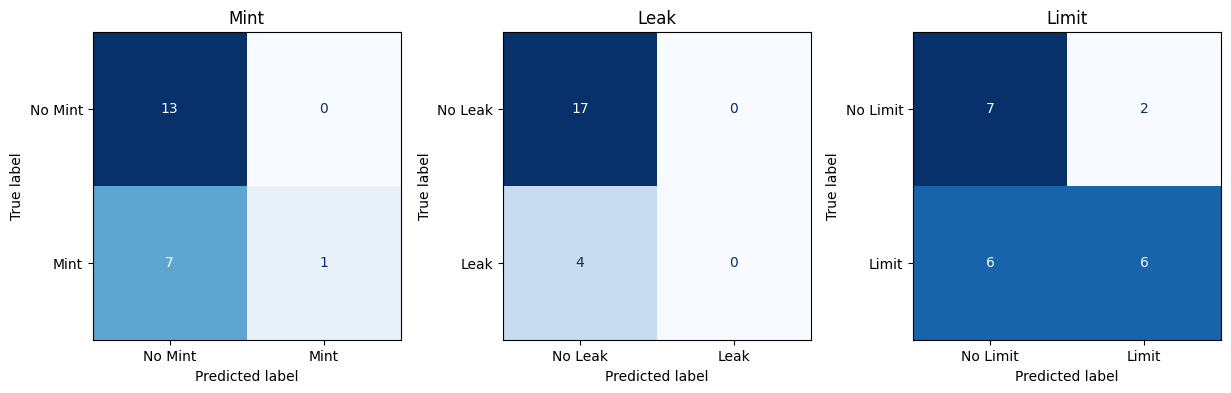

In [124]:
common_addrs = list(C_dynamic_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_dynamic_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


### Option F: Bayesian Fusion

In [125]:
C_bayes_preds = {}
C_bayes_probs = {}

for addr in set.union(*[set(prob.keys()) for prob in available_prob.values()]):
    prob_list = []

    for model_name in available_prob:
        if addr in available_prob[model_name]:
            prob_list.append(np.array(available_prob[model_name][addr]))

    if len(prob_list) == 0:
        continue

    probs = np.stack(prob_list)  # shape: (n_models, n_labels)

    # Product of experts
    product = np.prod(probs + 1e-8, axis=0)
    complement = np.prod(1 - probs + 1e-8, axis=0)
    fused_probs = product / (product + complement)

    fused = fused_probs > 0.5  # you can tune this threshold

    C_bayes_probs[addr] = fused_probs
    C_bayes_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       0.67      0.25      0.36         8
        Leak       0.00      0.00      0.00         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.75      0.38      0.50        24
   macro avg       0.48      0.28      0.34        24
weighted avg       0.61      0.38      0.45        24
 samples avg       0.33      0.31      0.31        24



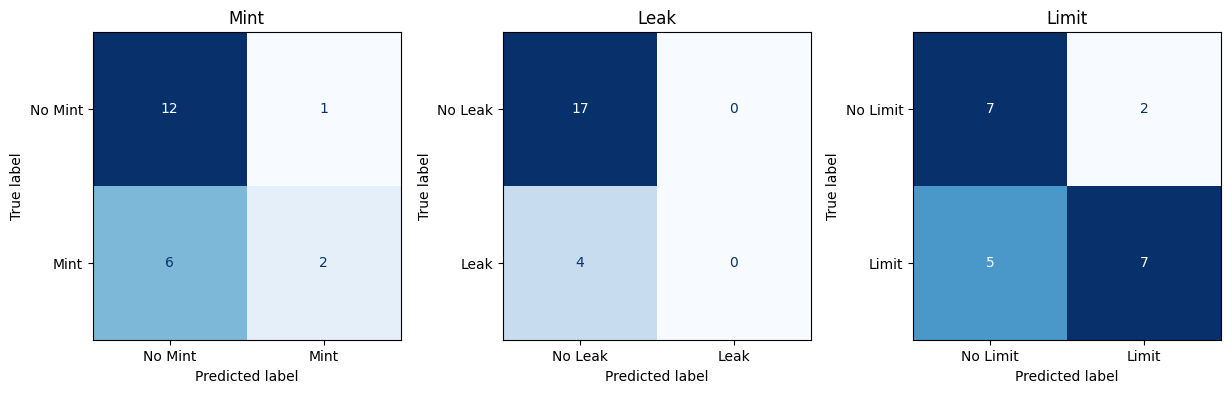

In [126]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_bayes_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_bayes_preds[addr] for addr in common_addrs])
y_probs = np.array([C_bayes_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [127]:
C_final_preds

{'0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7': array([1, 1, 1]),
 '0x10f6f2b97f3ab29583d9d38babf2994df7220c21': array([1, 0, 1]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([1, 0, 1]),
 '0x82902c20c5826984588dcd2dfcc322e05dcc435c': array([0, 0, 1]),
 '0x93023f1d3525e273f291b6f76d2f5027a39bf302': array([0, 0, 1]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([1, 0, 1]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([1, 1, 1]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 1]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 1]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([0, 0, 0]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([0, 0, 0]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([1, 0, 1]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0xd217dc0cab1c952a7ce6f4d7ca4549cde1f37bb0': array([1, 0, 0]),
 '0x11cbc781dadaad13fc3a3

### Oprion G: Confidence-Based Fusion

In [128]:
C_confidence_preds = {}
C_confidence_probs = {}

for addr in set.union(*[set(prob.keys()) for prob in available_prob.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))

    for model_name, prob_dict in available_prob.items():
        if addr in prob_dict:
            prob = np.array(prob_dict[addr])                   # shape: (n_labels,)
            confidence = np.abs(prob - 0.5)                    # Confidence per label

            weighted_sum += prob * confidence
            total_weight += confidence

    fused_probs = weighted_sum / np.maximum(total_weight, 1e-8)  # Avoid division by zero
    fused = fused_probs > 0.3  # Threshold can be tuned

    C_confidence_probs[addr] = fused_probs
    C_confidence_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       0.56      0.62      0.59         8
        Leak       0.00      0.00      0.00         4
       Limit       0.75      1.00      0.86        12

   micro avg       0.68      0.71      0.69        24
   macro avg       0.44      0.54      0.48        24
weighted avg       0.56      0.71      0.62        24
 samples avg       0.55      0.52      0.51        24



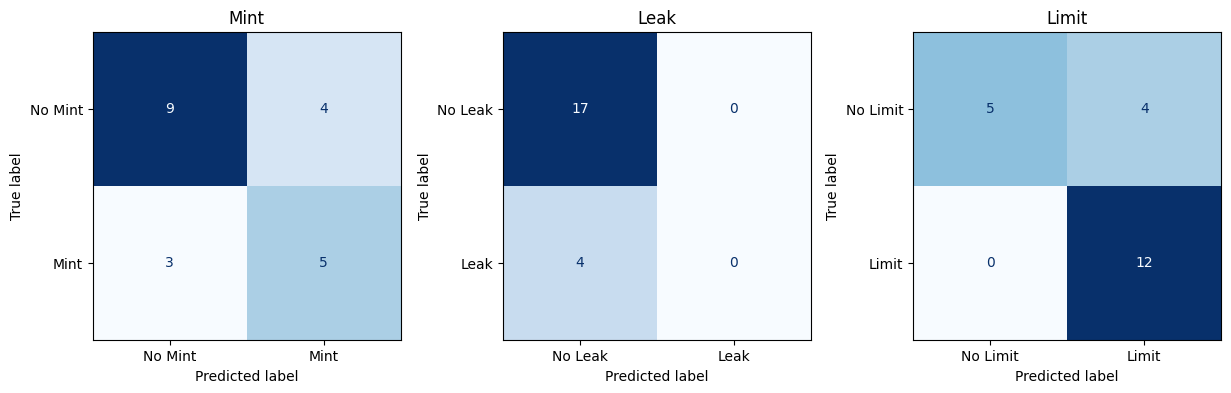

In [129]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_confidence_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_confidence_preds[addr] for addr in common_addrs])
y_probs = np.array([C_confidence_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [130]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-29 18:57:29,521] A new study created in memory with name: no-name-d1b95147-86a9-4cc7-a884-45aadb662dcd
[I 2025-07-29 18:57:29,527] Trial 0 finished with value: 0.28205128205128205 and parameters: {'thresh_Mint': 0.8204521540580498, 'thresh_Leak': 0.8199274128279461, 'thresh_Limit': 0.41846757476408863}. Best is trial 0 with value: 0.28205128205128205.
[I 2025-07-29 18:57:29,531] Trial 1 finished with value: 0.3434343434343434 and parameters: {'thresh_Mint': 0.5970506565169102, 'thresh_Leak': 0.7816464118561883, 'thresh_Limit': 0.496442667108373}. Best is trial 1 with value: 0.3434343434343434.
[I 2025-07-29 18:57:29,536] Trial 2 finished with value: 0.3636363636363636 and parameters: {'thresh_Mint': 0.4892726041780835, 'thresh_Leak': 0.5902905832401963, 'thresh_Limit': 0.44623721927624604}. Best is trial 2 with value: 0.3636363636363636.
[I 2025-07-29 18:57:29,540] Trial 3 finished with value: 0.19999999999999998 and parameters: {'thresh_Mint': 0.7978470784758673, 'thresh_Le

Best Thresholds: [0.30306443 0.4354274  0.30190154]


              precision    recall  f1-score   support

        Mint       0.56      0.62      0.59         8
        Leak       0.00      0.00      0.00         4
       Limit       0.75      1.00      0.86        12

   micro avg       0.68      0.71      0.69        24
   macro avg       0.44      0.54      0.48        24
weighted avg       0.56      0.71      0.62        24
 samples avg       0.55      0.52      0.51        24



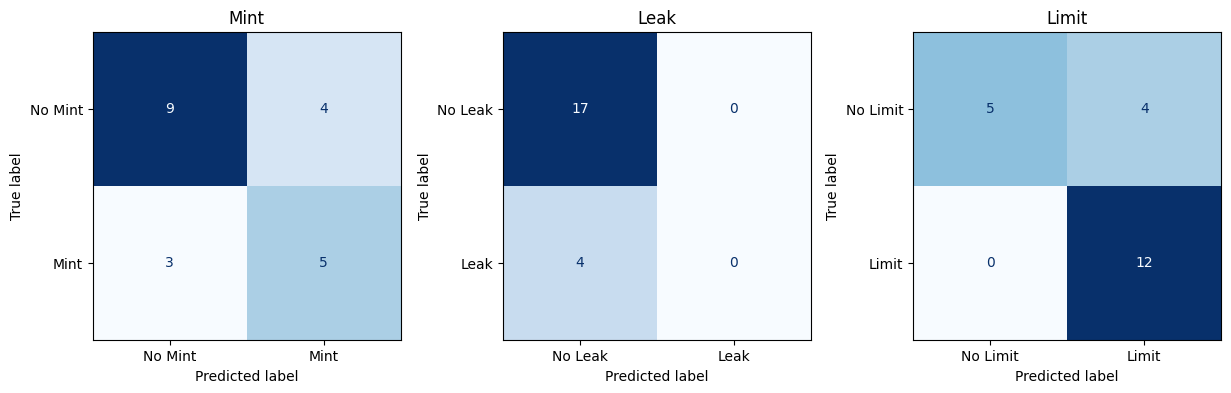

In [131]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)